In [1]:
import os
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import pickle
import copy
from collections import OrderedDict
import matplotlib.patches as patches
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from torch.utils.data import random_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn.functional as F
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.4.1
0.19.1


In [3]:
device = torch.device('cpu')

# Loading Dataset

In [4]:
data_dir = Path('./data/')

dataset_csv = data_dir / 'dataset.csv'
df = pd.read_csv(dataset_csv, sep=',')

print(f"number of records in csv file: {len(df)}")
df

number of records in csv file: 20327


filestem  patient_id  study_number    timehash  \
0      0001_1297860395_01_WRI-L1_M014           1             1  1297860395   
1      0001_1297860435_01_WRI-L2_M014           1             1  1297860435   
2      0002_0354485735_01_WRI-R1_F012           2             1   354485735   
3      0002_0354485759_01_WRI-R2_F012           2             1   354485759   
4      0003_0662359226_01_WRI-R1_M011           3             1   662359226   
...                               ...         ...           ...         ...   
20322  6091_0590289015_02_WRI-L2_F008        6091             2   590289015   
20323  6092_0295935784_01_WRI-L1_M003        6092             1   295935784   
20324  6092_0295935837_01_WRI-L2_M003        6092             1   295935837   
20325  6093_0885712402_01_WRI-L1_M008        6093             1   885712402   
20326  6093_0885712456_01_WRI-L2_M008        6093             1   885712456   

      gender   age laterality  projection  initial_exam ao_classification  \
0          M  14.1          L           1           1.0         23r-M/2.1   
1          M  14.1          L           2           1.0         23r-M/2.1   
2          F  12.0          R           1           1.0         23r-M/2.1   
3          F  12.0          R           2           1.0         23r-M/2.1   
4          M  11.1          R           1           1.0          23-M/3.1   
...      ...   ...        ...         ...           ...               ...   
20322      F   8.7          L           2           1.0               NaN   
20323      M   3.5          L           1           1.0          22-D/1.1   
20324      M   3.5          L           2           1.0          22-D/1.1   
20325      M   8.4          L           1           1.0         23r-M/3.1   
20326      M   8.4          L           2           1.0         23r-M/3.1   

       cast  diagnosis_uncertain  osteopenia  fracture_visible  metal  \
0       NaN                  NaN         NaN               NaN    NaN   
1       NaN                  NaN         NaN               1.0    NaN   
2       NaN                  1.0         NaN               NaN    NaN   
3       NaN                  1.0         NaN               NaN    NaN   
4       NaN                  NaN         NaN               1.0    NaN   
...     ...                  ...         ...               ...    ...   
20322   NaN                  NaN         NaN               NaN    NaN   
20323   NaN                  NaN         NaN               NaN    NaN   
20324   NaN                  NaN         NaN               NaN    NaN   
20325   NaN                  NaN         NaN               1.0    NaN   
20326   NaN                  NaN         NaN               1.0    NaN   

       pixel_spacing device_manufacturer  
0              0.144             Siemens  
1              0.144             Siemens  
2              0.144             Siemens  
3              0.144             Siemens  
4              0.144             Siemens  
...              ...                 ...  
20322          0.144             Siemens  
20323          0.144             Siemens  
20324          0.144             Siemens  
20325          0.144             Siemens  
20326          0.144             Siemens  

[20327 rows x 17 columns]

In [5]:
# annotations
ann_dir = data_dir / 'supervisely' / 'wrist' / 'ann'
ann_files_path = data_dir / 'ann_files.pkl'
fracture_ann_files_path = data_dir / 'fracture_ann_files.pkl'


def save_list_to_pickle(data_list, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(data_list, f)

def load_list_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

if ann_files_path.exists() and fracture_ann_files_path.exists():
    print("Loading files from pickle file")
    ann_files = load_list_from_pickle(ann_files_path)
    fracture_ann_files = load_list_from_pickle(fracture_ann_files_path)
    ann_files = [Path(ann) for ann in ann_files]
    fracture_ann_files = [Path(ann) for ann in fracture_ann_files]
else:
    print("Generating new files")
    ann_files = list(ann_dir.glob('*.json'))
    ann_files = [str(ann) for ann in ann_files]

    print(f"Number of annotation files: {len(ann_files)}")

    def has_fracture(ann_path):
        with open(ann_path, 'r') as f:
            data = json.load(f)
            for obj in data['objects']:
                if obj['classTitle'] == 'fracture':
                    return True
        return False

    # annotations with 'fracture' label
    fracture_ann_files = [ann for ann in ann_files if has_fracture(ann)]

    print(f"Number of annotation files with 'fracture' label: {len(fracture_ann_files)}")

    save_list_to_pickle(ann_files, ann_files_path)
    save_list_to_pickle(fracture_ann_files, fracture_ann_files_path)

Loading files from pickle file


In [6]:
# create a list of base filenames (without extensions) for 'fracture' images
fracture_filenames = [ann.stem for ann in fracture_ann_files]

# df filtering based on filenames with 'fracture' images
df_fracture = df[df['filestem'].isin(fracture_filenames)]

print(f"Number of records in df_fracture: {len(df_fracture)}")
df_fracture

Number of records in df_fracture: 13550


filestem  patient_id  study_number    timehash  \
1      0001_1297860435_01_WRI-L2_M014           1             1  1297860435   
4      0003_0662359226_01_WRI-R1_M011           3             1   662359226   
5      0003_0662359351_01_WRI-R2_M011           3             1   662359351   
6      0003_0663715732_02_WRI-R1_M011           3             2   663715732   
7      0003_0663715782_02_WRI-R2_M011           3             2   663715782   
...                               ...         ...           ...         ...   
20318  6090_0842599926_01_WRI-L2_M011        6090             1   842599926   
20319  6090_0843973809_02_WRI-L1_M011        6090             2   843973809   
20320  6090_0843973872_02_WRI-L2_M011        6090             2   843973872   
20325  6093_0885712402_01_WRI-L1_M008        6093             1   885712402   
20326  6093_0885712456_01_WRI-L2_M008        6093             1   885712456   

      gender   age laterality  projection  initial_exam     ao_classification  \
1          M  14.1          L           2           1.0             23r-M/2.1   
4          M  11.1          R           1           1.0              23-M/3.1   
5          M  11.1          R           2           1.0              23-M/3.1   
6          M  11.2          R           1           NaN              23-M/3.1   
7          M  11.2          R           2           NaN              23-M/3.1   
...      ...   ...        ...         ...           ...                   ...   
20318      M  11.0          L           2           NaN  23r-M/3.1; 23u-M/2.1   
20319      M  11.1          L           1           NaN  23r-M/3.1; 23u-M/2.1   
20320      M  11.1          L           2           NaN  23r-M/3.1; 23u-M/2.1   
20325      M   8.4          L           1           1.0             23r-M/3.1   
20326      M   8.4          L           2           1.0             23r-M/3.1   

       cast  diagnosis_uncertain  osteopenia  fracture_visible  metal  \
1       NaN                  NaN         NaN               1.0    NaN   
4       NaN                  NaN         NaN               1.0    NaN   
5       NaN                  NaN         NaN               1.0    NaN   
6       1.0                  NaN         NaN               1.0    NaN   
7       1.0                  NaN         NaN               1.0    NaN   
...     ...                  ...         ...               ...    ...   
20318   1.0                  NaN         NaN               1.0    NaN   
20319   NaN                  NaN         1.0               1.0    NaN   
20320   NaN                  NaN         1.0               1.0    NaN   
20325   NaN                  NaN         NaN               1.0    NaN   
20326   NaN                  NaN         NaN               1.0    NaN   

       pixel_spacing device_manufacturer  
1              0.144             Siemens  
4              0.144             Siemens  
5              0.144             Siemens  
6              0.144             Siemens  
7              0.144             Siemens  
...              ...                 ...  
20318          0.144             Siemens  
20319          0.144             Siemens  
20320          0.144             Siemens  
20325          0.144             Siemens  
20326          0.144             Siemens  

[13550 rows x 17 columns]

In [7]:
num_patients = df_fracture['patient_id'].nunique()
print(f"Number of unique patients with 'fracture': {num_patients}")

Number of unique patients with 'fracture': 3587


# Dataset statistics

Gender counts:
gender
M    8731
F    4819
Name: count, dtype: int64


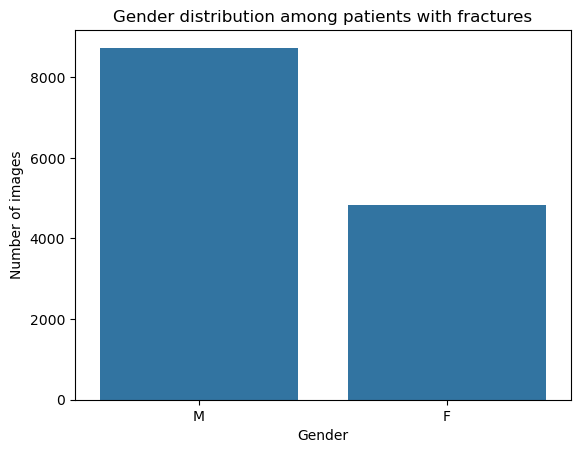

In [8]:
gender_counts = df_fracture['gender'].value_counts()
print("Gender counts:")
print(gender_counts)

# Plot of gender distribution
sns.countplot(data=df_fracture, x='gender')
plt.title('Gender distribution among patients with fractures')
plt.xlabel('Gender')
plt.ylabel('Number of images')
plt.show()

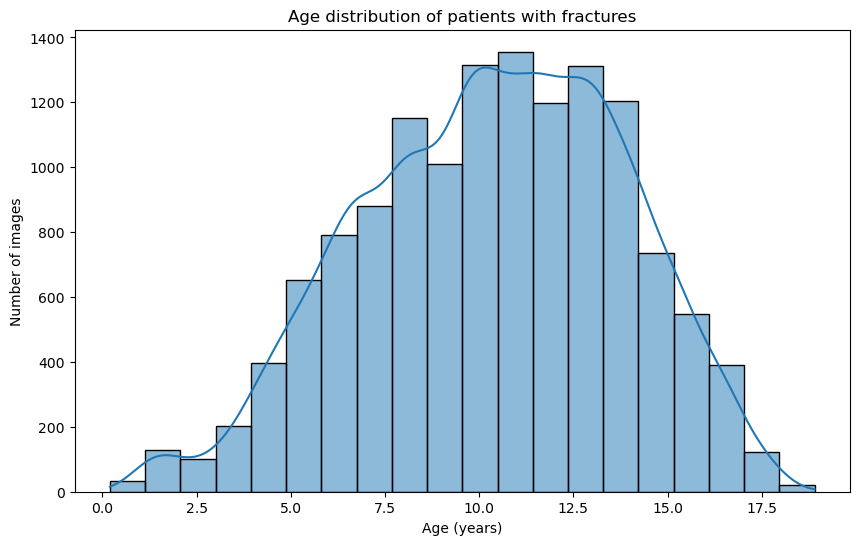

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(df_fracture['age'], bins=20, kde=True)
plt.title('Age distribution of patients with fractures')
plt.xlabel('Age (years)')
plt.ylabel('Number of images')
plt.show()

In [10]:
print("Unique values in the 'projection' column:")
print(df_fracture['projection'].unique())

Unique values in the 'projection' column:
[2 1 3]


In [11]:
# mapping projection with name
projection_mapping = {1: 'PA', 2: 'Lateral'}
df_fracture['projection_name'] = df_fracture['projection'].map(projection_mapping)
df_fracture[['projection', 'projection_name']]

/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_25078/1391805771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fracture['projection_name'] = df_fracture['projection'].map(projection_mapping)


projection projection_name
1               2         Lateral
4               1              PA
5               2         Lateral
6               1              PA
7               2         Lateral
...           ...             ...
20318           2         Lateral
20319           1              PA
20320           2         Lateral
20325           1              PA
20326           2         Lateral

[13550 rows x 2 columns]

Number of images for each projection:
projection_name
Lateral    6924
PA         6553
Name: count, dtype: int64


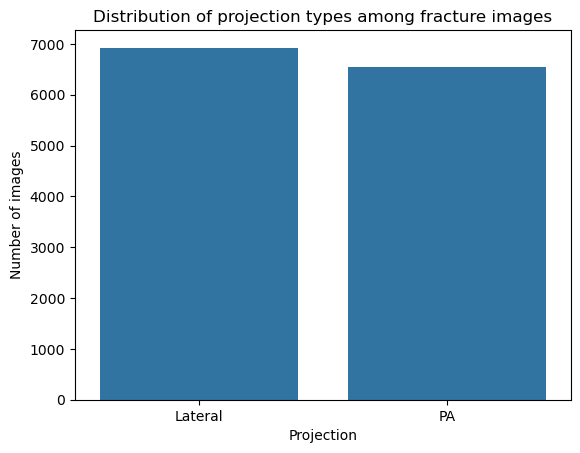

In [12]:
projection_counts = df_fracture['projection_name'].value_counts()
print("Number of images for each projection:")
print(projection_counts)

sns.countplot(data=df_fracture, x='projection_name')
plt.title('Distribution of projection types among fracture images')
plt.xlabel('Projection')
plt.ylabel('Number of images')
plt.show()

# Train, Valid, Test split

In [13]:
all_filenames = df_fracture['filestem'].tolist()

train_filenames, temp_filenames = train_test_split(all_filenames, test_size=0.3, random_state=42)
val_filenames, test_filenames = train_test_split(temp_filenames, test_size=1/3, random_state=42)

print(f"Number of images in the training set: {len(train_filenames)}")
print(f"Number of images in the validation set: {len(val_filenames)}")
print(f"Number of images in the test set: {len(test_filenames)}")

Number of images in the training set: 9485
Number of images in the validation set: 2710
Number of images in the test set: 1355


# Dataset Class and Loaders

In [14]:
class FractureDataset(Dataset):
    def __init__(self, file_list, img_dir, ann_dir, transforms=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filestem = self.file_list[idx]
        img_path = self.img_dir / (filestem + '.png')
        ann_path = self.ann_dir / (filestem + '.json')
        
        # loading images
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        
        # loading annotations
        with open(ann_path, 'r') as f:
            data = json.load(f)
        
        boxes = []
        labels = []
        img_height, img_width = img.shape[:2]
        
        for obj in data['objects']:
            if obj['classTitle'] == 'fracture':
                points = obj['points']['exterior']
                x_min = min(points[0][0], points[1][0])
                x_max = max(points[0][0], points[1][0])
                y_min = min(points[0][1], points[1][1])
                y_max = max(points[0][1], points[1][1])
                
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_width, x_max)
                y_max = min(img_height, y_max)
                
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(1)  # 1 for 'fracture' annotations
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        
        # additional fields required by Faster R-CNN
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['area'] = area
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

In [15]:
def get_transform(train):
    transforms_list = []
    transforms_list.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(transforms_list)

In [16]:
def sample_filenames(filenames, percentage=0.01):
    sample_size = int(len(filenames) * percentage)
    return random.sample(filenames, sample_size)

In [17]:
use_smaller_dataset = False

if use_smaller_dataset:
    percentage = 0.01
    print(f"Using a sampled subset of the dataset ({percentage*100}% sample) for the analysis")
    train_filenames = sample_filenames(train_filenames, percentage=percentage)
    val_filenames = sample_filenames(val_filenames, percentage=percentage)
    test_filenames = sample_filenames(test_filenames, percentage=percentage)
else:
    print("Using the full dataset for the analysis")

Using the full dataset for the analysis


In [18]:
# images directory
img_dir = data_dir / 'supervisely' / 'wrist' / 'img'

train_dataset = FractureDataset(train_filenames, img_dir, ann_dir, transforms=get_transform(train=True))
val_dataset = FractureDataset(val_filenames, img_dir, ann_dir, transforms=get_transform(train=False))
test_dataset = FractureDataset(test_filenames, img_dir, ann_dir, transforms=get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [19]:
train_filenames_path = data_dir / 'train_filenames.pkl'
val_filenames_path = data_dir / 'val_filenames.pkl'
test_filenames_path = data_dir / 'test_filenames.pkl'


if not train_filenames_path.exists():
    with open(train_filenames_path, 'wb') as f:
        pickle.dump(train_filenames, f)

if not val_filenames_path.exists():
    with open(val_filenames_path, 'wb') as f:
        pickle.dump(val_filenames, f)

if not test_filenames_path.exists():
    with open(test_filenames_path, 'wb') as f:
        pickle.dump(test_filenames, f)

# Model

In [20]:
def get_model(num_classes):
    # pre-trained resnet50 with fpn model on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    
    # number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the predefined classifier with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

num_classes = 2  # 1 ('fracture') + background
model = get_model(num_classes)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training

In [21]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [22]:
save_dir = data_dir / 'models'
os.makedirs(save_dir, exist_ok=True)

In [23]:
train_losses_per_epoch = []
val_losses_per_epoch = []
train_losses_per_step = []

In [24]:
num_epochs = 10

In [25]:
def eval_forward(model, images, targets):
    model.eval()
    
    original_image_sizes = []
    for img in images:
        val = img.shape[-2:]
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)
    
    # Backbone feature extraction
    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])

    # RPN (Region Proposal Network) computation
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)
    
    # num anchors per level
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]

    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(len(anchors), -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    if targets is not None:
        labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
        regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
        loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
            objectness, pred_bbox_deltas, labels, regression_targets
        )
        proposal_losses = {
            "loss_objectness": loss_objectness,
            "loss_rpn_box_reg": loss_rpn_box_reg,
        }

    # ROI (Region of Interest) computation
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, images.image_sizes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)

    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    
    # Postprocess detections
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, images.image_sizes)
    detections = [{"boxes": b, "labels": l, "scores": s} for b, l, s in zip(boxes, labels, scores)]
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)

    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    
    return losses, detections

In [26]:
@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        losses, _ = eval_forward(model, images, targets)

        val_loss += sum(loss.item() for loss in losses.values())

    # avg loss on the validation set
    validation_loss = val_loss / len(data_loader)
    return validation_loss

In [27]:
final_model_save_path = save_dir / "fast_rcnn_final_model_and_states.pth"

if final_model_save_path.exists():
    print(f"Trained model already exists at path: {final_model_save_path}. Skipping training")
else:
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()

        train_epoch_losses = []
        for i, (images, targets) in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}")):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_epoch_losses.append(losses.item())
            if i % 10 == 0:
                print(f'Step {i}, Loss: {losses.item()}')
        
        avg_train_loss = np.mean(train_epoch_losses)
        train_losses_per_epoch.append(avg_train_loss)
        print(f'Avg training loss: {avg_train_loss:.4f}')
        
        lr_scheduler.step()

        avg_val_loss = evaluate_loss(model, val_loader, device=device)
        val_losses_per_epoch.append(avg_val_loss)
        print(f'Avg validation loss: {avg_val_loss:.4f}')


        # Saving model and losses
        model_save_path = save_dir / f"fast_rcnn_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_save_path)

        train_losses_save_path = save_dir / "fast_rcnn_train_losses_per_epoch.pth"
        torch.save(train_losses_per_epoch, train_losses_save_path)

        val_losses_save_path = save_dir / "fast_rcnn_val_losses_per_epoch.pth"
        torch.save(val_losses_per_epoch, val_losses_save_path)


    # Saving final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': lr_scheduler.state_dict(),
        'epoch': num_epochs,
        'train_losses': train_losses_per_epoch,
        'val_losses': val_losses_per_epoch
    }, final_model_save_path)

Trained model already exists at path: data/models/fast_rcnn_final_model_and_states.pth. Skipping training


- load saved final model

In [28]:
if final_model_save_path.exists():
    checkpoint = torch.load(final_model_save_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch = checkpoint['epoch']
    train_losses_per_epoch = checkpoint['train_losses']
    val_losses_per_epoch = checkpoint['val_losses']

    print(f"Loaded model state from epoch {epoch}")

/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_25078/2837021930.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(final_model_save_path

Loaded model state from epoch 10


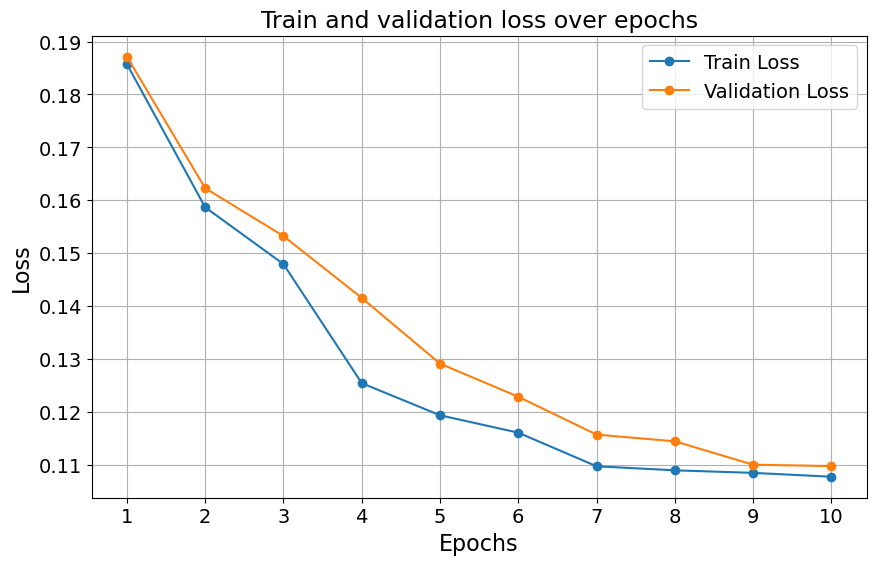

In [29]:
epochs = range(1, len(train_losses_per_epoch) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_per_epoch, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, val_losses_per_epoch, label='Validation Loss', marker='o', linestyle='-')
plt.title('Train and validation loss over epochs', fontsize=17)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(epochs)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

# Results for base model with default ROI threshold values

In [30]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [31]:
def plot_image_with_boxes(image, boxes, color='green', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(8, 8))
    
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # permute from [C, H, W] to [H, W, C]

    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    return ax

In [32]:
def get_batch_by_idx(loader, idx):
    for i, (images, targets) in enumerate(loader):
        if i == idx:
            return images, targets
    raise IndexError(f"Index {idx} is out of the loader range")

In [34]:
def process_and_plot(loader, idx, row_idx, title_prefix, axs, num_rows, model, num_images_to_show):
    images, targets = get_batch_by_idx(loader, idx)

    with torch.no_grad():
        predictions = model([img.to(device) for img in images])

    for i in range(min(num_images_to_show, len(images))):
        image = images[i]
        target_boxes = targets[i]['boxes']
        pred_boxes = predictions[i]['boxes'].cpu()

        # plot ground truth
        ax = plot_image_with_boxes(image, target_boxes, color='green',
                                    ax=axs[row_idx, 2 * i] if num_rows > 1 else axs[2 * i])
        ax.set_title(f'{title_prefix} Image {i+1}\n- Ground Truth', fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])

        # plot predictions
        ax = plot_image_with_boxes(image, pred_boxes, color='red',
                                    ax=axs[row_idx, 2 * i + 1] if num_rows > 1 else axs[2 * i + 1])
        ax.set_title(f'{title_prefix} Image {i+1}\n- Predictions', fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])

In [35]:
def model_predict(model, train_loader=None, idx_train=None, val_loader=None, idx_val=None, test_loader=None, idx_test=None, num_images_to_show=4, seed=42):
    set_seed(seed)
    num_rows = 0
    if train_loader is not None and idx_train is not None:
        num_rows += 1
    if val_loader is not None and idx_val is not None:
        num_rows += 1
    if test_loader is not None and idx_test is not None:
        num_rows += 1

    if num_rows == 0:
        raise ValueError("At least one loader with a valid index must be provided.")

    num_cols = num_images_to_show * 2

    model.eval()

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))

    row_idx = 0
    if train_loader is not None and idx_train is not None:
        process_and_plot(train_loader, idx_train, row_idx, "Train", axs, num_rows, model, num_images_to_show)
        row_idx += 1

    if val_loader is not None and idx_val is not None:
        process_and_plot(val_loader, idx_val, row_idx, "Valid.", axs, num_rows, model, num_images_to_show)
        row_idx += 1

    if test_loader is not None and idx_test is not None:
        process_and_plot(test_loader, idx_test, row_idx, "Test", axs, num_rows, model, num_images_to_show)

    plt.tight_layout()
    plt.show()

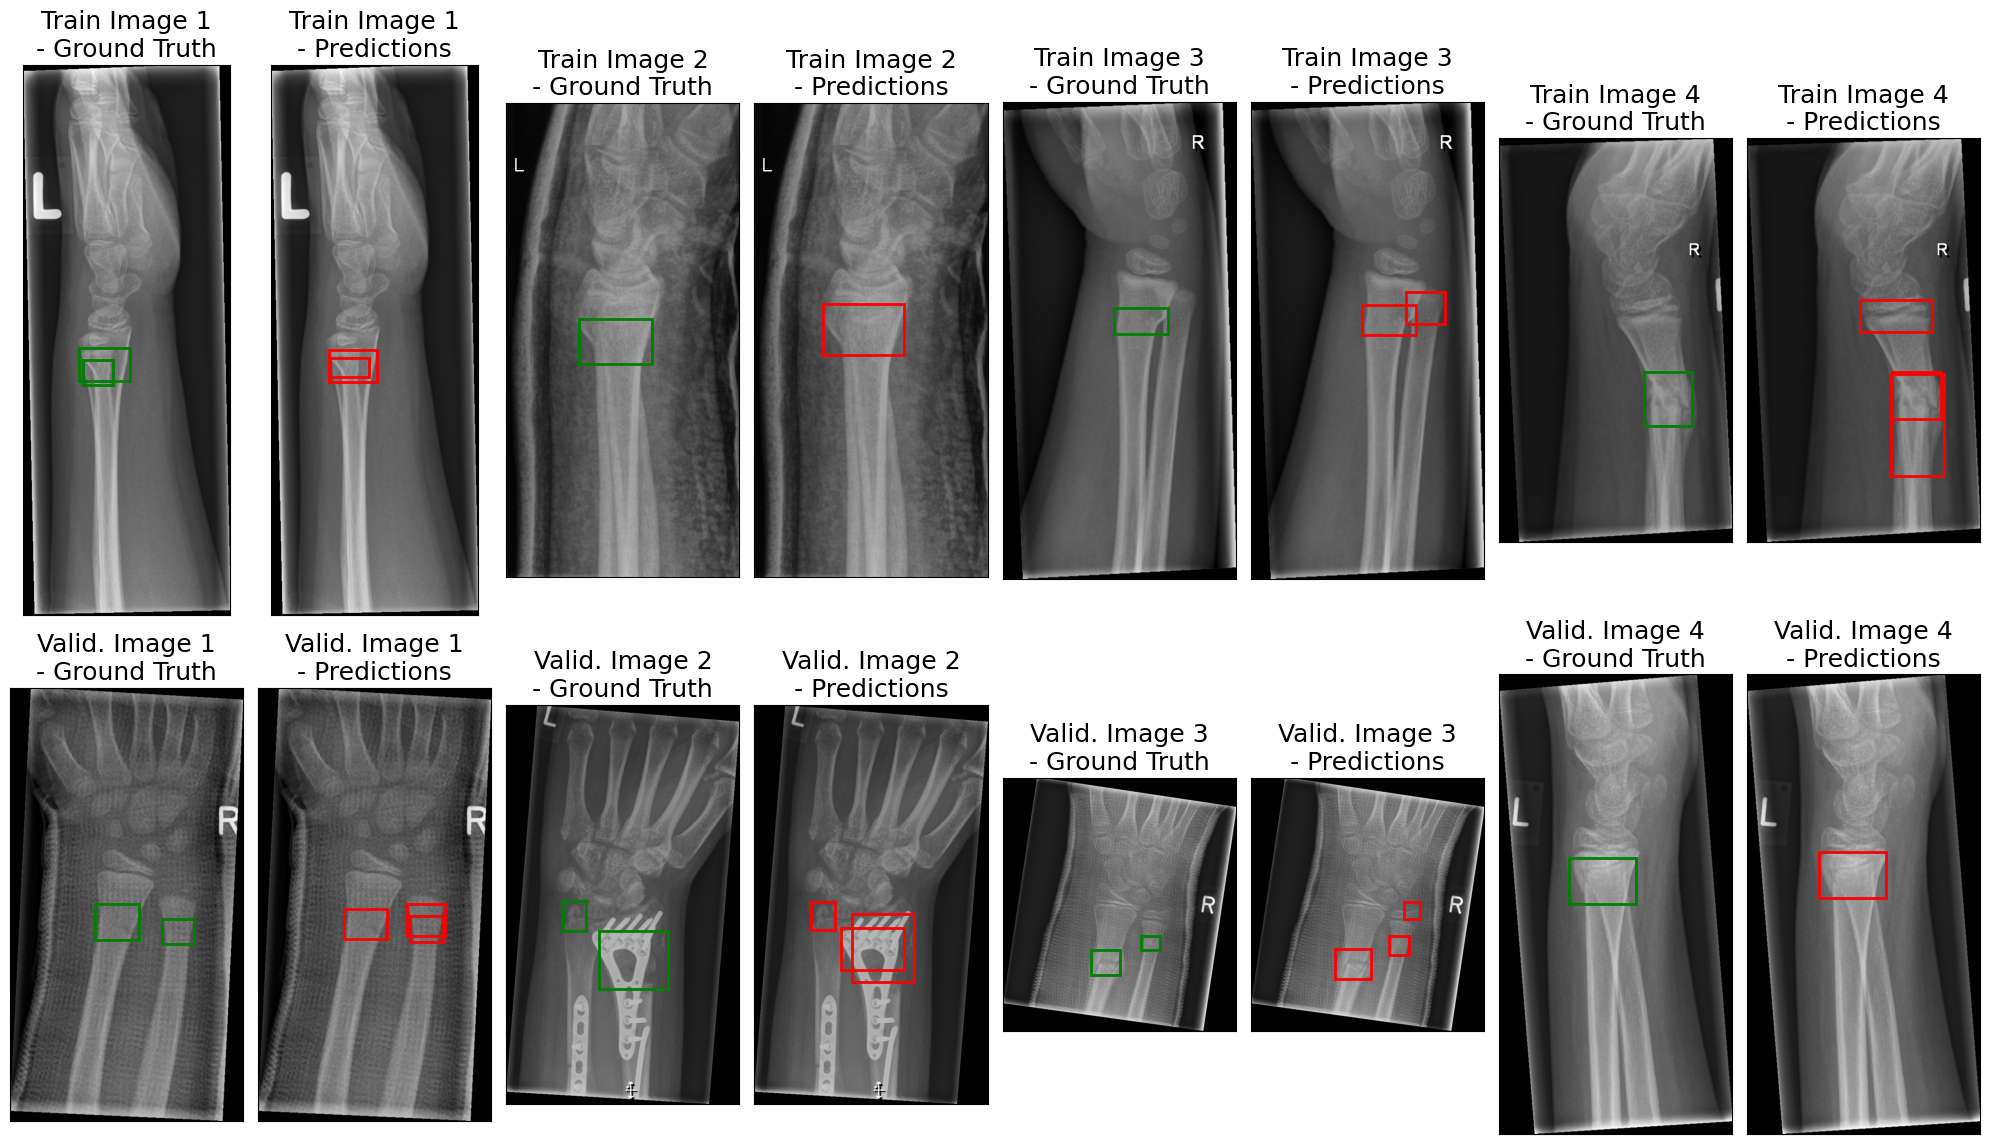

In [36]:
model_predict(model, train_loader=train_loader, idx_train=0, val_loader=val_loader, idx_val=0)

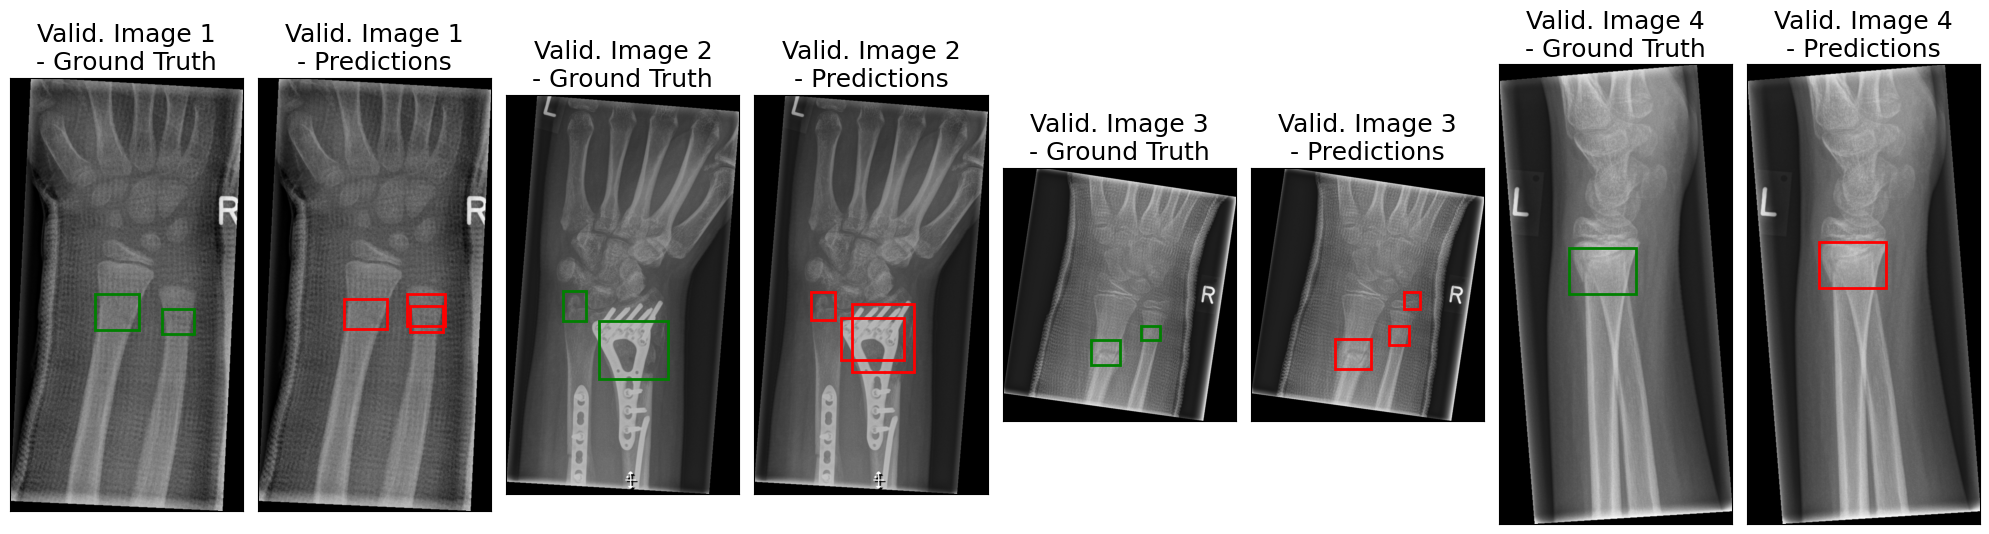

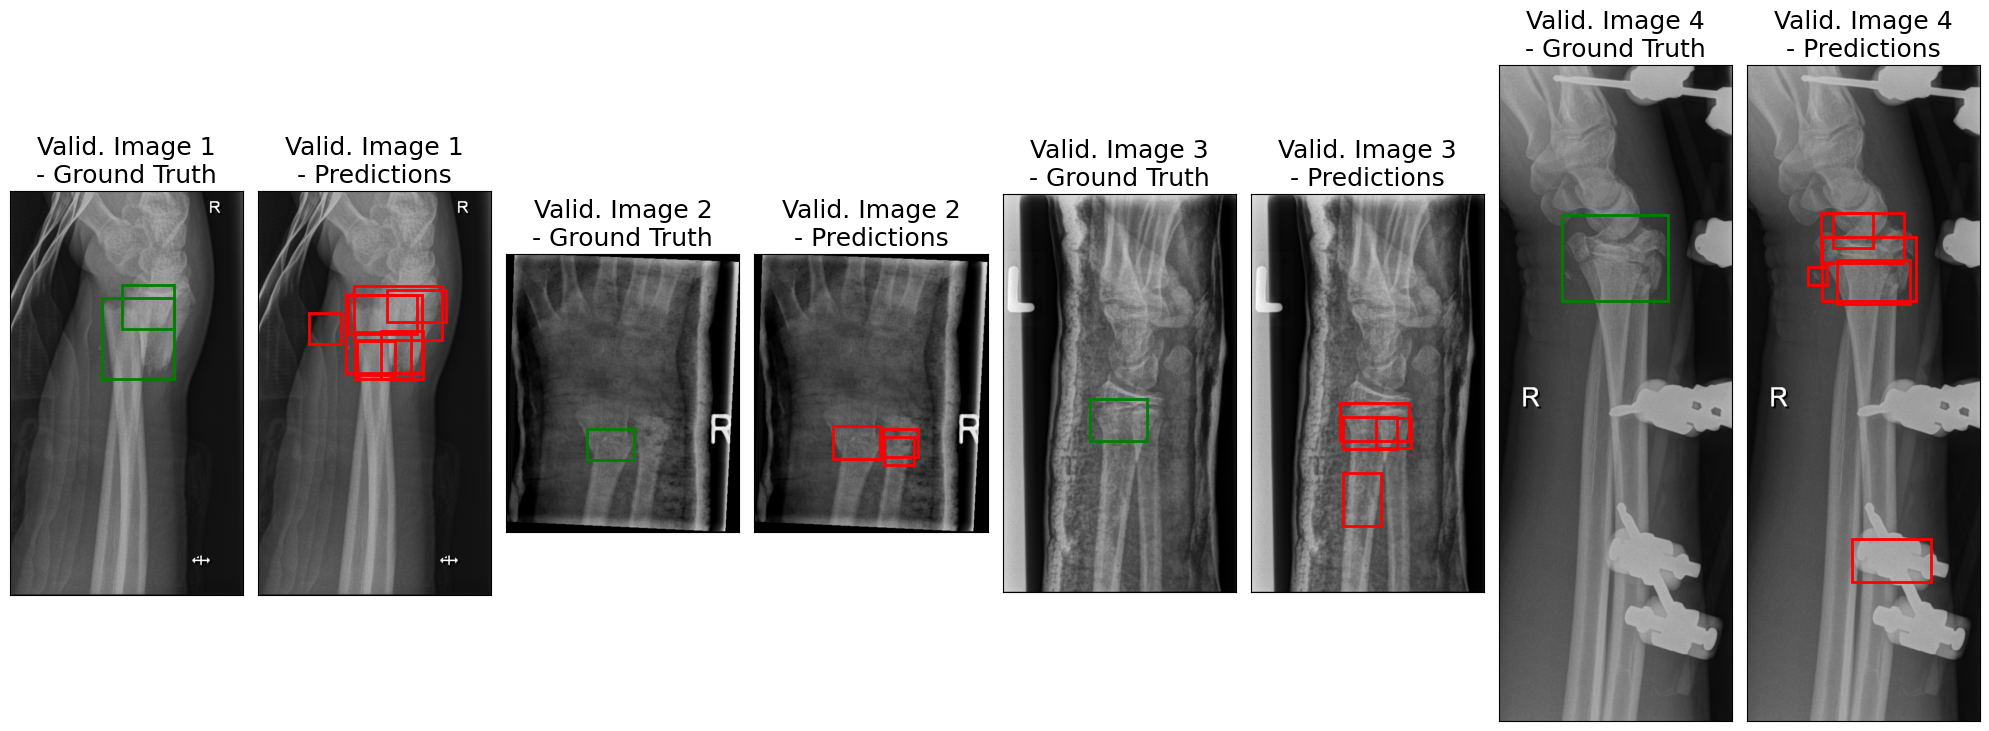

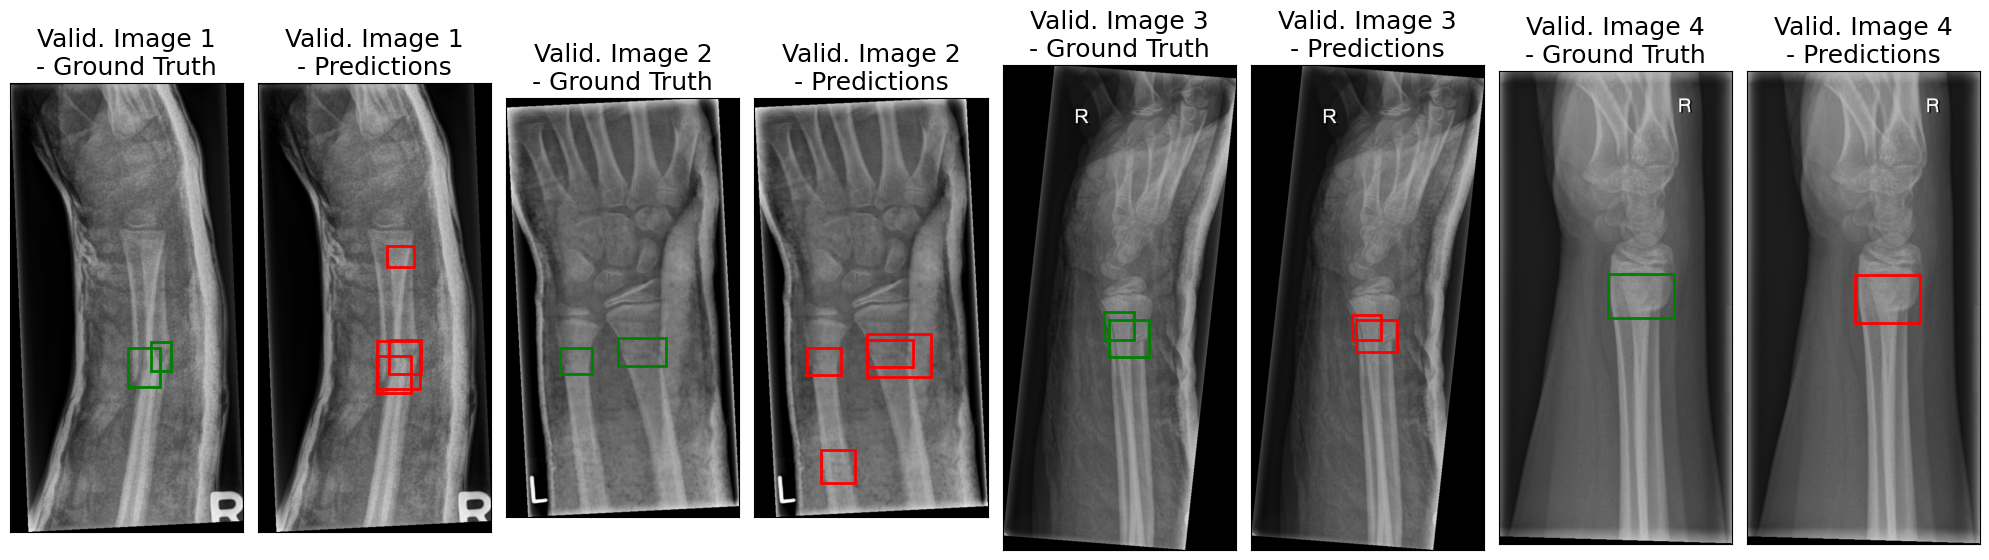

In [37]:
for i in range(3):
    model_predict(model, val_loader=val_loader, idx_val=i)

# Evaluation pipeline for Faster R-CNN with ROI threshold optimization

This section implements an evaluation pipeline for the Faster R-CNN model, focusing on optimizing Region of Interest (ROI) thresholds (NMS and score thresholds). It includes functions for modifying ROI thresholds, calculating IoU, precision, recall, and mAP, and evaluating performance across different parameter configurations. The pipeline also identifies the best-performing model and saves the results for further analysis.

In [38]:
def modify_model_roi_thresholds(model, nms_thresh=0.7, score_thresh=0.5):
    model_copy = copy.deepcopy(model)

    model_copy.roi_heads.nms_thresh = nms_thresh
    model_copy.roi_heads.score_thresh = score_thresh

    return model_copy

In [39]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection

    iou = intersection / union if union > 0 else 0.0
    return iou

In [40]:
def collect_predictions(model, loader, start_idx=0, end_idx=-1):
    all_data = []

    model.eval()

    # if end_idx is not provided, set it to the length of the loader (process all batches)
    if end_idx == -1:
        end_idx = len(loader)

    for batch_idx, (images, targets) in enumerate(loader):
        # checking if batch_idx is within the specified range
        if batch_idx < start_idx or batch_idx >= end_idx:
            continue

        images = list(image.to(device) for image in images)
        with torch.no_grad():
            predictions = model(images)

        for i in range(len(images)):
            pred_boxes = predictions[i]['boxes'].cpu().numpy()
            confidence_scores = predictions[i]['scores'].cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()
            image_id = targets[i]['image_id'].item()

            # grouping predictions, confidence scores, and ground truth for each image
            all_data.append({
                'pred_boxes': pred_boxes,
                'true_boxes': true_boxes,
                'confidence_scores': confidence_scores,
                'image_id': image_id
            })

    return all_data

In [41]:
def get_precision_and_recall(all_data, iou_threshold):
    pred_boxes = []
    true_boxes = []
    confidence_scores = []
    image_ids = []

    for data in all_data:
        pred_boxes.extend(data['pred_boxes'])
        true_boxes.extend(data['true_boxes'])
        confidence_scores.extend(data['confidence_scores'])
        image_ids.extend([data['image_id']] * len(data['pred_boxes']))

    pred_boxes = np.array(pred_boxes)
    true_boxes = np.array(true_boxes)
    confidence_scores = np.array(confidence_scores)
    image_ids = np.array(image_ids)

    sorted_indices = np.argsort(-confidence_scores)
    sorted_pred_boxes = pred_boxes[sorted_indices]
    sorted_confidence_scores = confidence_scores[sorted_indices]
    sorted_image_ids = image_ids[sorted_indices]

    tp_list, fp_list = [], []
    total_true_boxes = 0
    matched_gt = set()
    gt_boxes_per_image = {}

    for data in all_data:
        gt_boxes_per_image[data['image_id']] = list(data['true_boxes'])
        total_true_boxes += len(data['true_boxes'])

    for i, pred_box in enumerate(sorted_pred_boxes):
        image_id = sorted_image_ids[i]
        gt_boxes = gt_boxes_per_image.get(image_id, [])

        max_iou = 0
        max_iou_idx = -1

        for gt_idx, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                max_iou_idx = gt_idx

        # True Positive
        if max_iou >= iou_threshold and (image_id, max_iou_idx) not in matched_gt:
            tp_list.append(1)
            fp_list.append(0)
            matched_gt.add((image_id, max_iou_idx))
        else:
            # False Positive
            tp_list.append(0)
            fp_list.append(1)

    tp_cumsum = np.cumsum(tp_list)
    fp_cumsum = np.cumsum(fp_list)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)  # Epsilon to avoid division by zero
    recalls = tp_cumsum / total_true_boxes

    return precisions, recalls

In [42]:
def calculate_map_score(precisions, recalls):
    # interpolated precision
    recalls = np.concatenate(([0], recalls, [1]))
    precisions = np.concatenate(([0], precisions, [0]))

    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    # area under Precision-Recall Curve (mAP)
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    map_score = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return map_score

In [43]:
def evaluate_model(model_to_evaluate, loader, start_idx, end_idx, iou_threshold):
    all_data = collect_predictions(model_to_evaluate, loader, start_idx, end_idx)
    precisions, recalls = get_precision_and_recall(all_data, iou_threshold)
    map_score = calculate_map_score(precisions, recalls)

    return map_score, precisions, recalls

In [44]:
def evaluate_multiple_combinations(model, val_loader, params, start_idx=0, end_idx=-1):
    params["results"] = {}

    # iteration over nms_thresh and score_thresh values
    for nms_thresh in params['nms_thresh']:
        for score_thresh in params['score_thresh']:
            # modifying model for different hyperparameters
            model_updated_roi = modify_model_roi_thresholds(model, nms_thresh=nms_thresh, score_thresh=score_thresh)

            # model evaluation for selected batches range (start_idx, end_idx)
            map_score, precisions, recalls = evaluate_model(
                model_updated_roi, val_loader, start_idx, end_idx, iou_threshold=0.5
            )

            key = f"nms_{nms_thresh:.2f}__conf_{score_thresh:.2f}"

            params["results"][key] = {
                'map_score': map_score,
                'precisions': precisions.tolist(),
                'recalls': recalls.tolist(),
                'nms_thresh': nms_thresh,
                'score_thresh': score_thresh,
                'iou_threshold': 0.5
            }

    return params

In [45]:
def analyze_best_model(model, val_loader, output_data, iou_thresholds, start_idx=0, end_idx=-1):
    # finding the best configuration based on mAP
    best_key = max(output_data["results"], key=lambda k: output_data["results"][k]['map_score'])
    best_model_params = output_data["results"][best_key]

    # analysing the best model for different IoU thresholds
    best_model_analysis = {}
    for iou_thresh in iou_thresholds:
        # evaluate for different IoU thresholds for selected batches range (start_idx, end_idx)
        map_score, precisions, recalls = evaluate_model(
            model, val_loader, start_idx, end_idx, iou_threshold=iou_thresh
        )

        key = f"iou_{iou_thresh:.2f}"
        best_model_analysis[key] = {
            'map_score': map_score,
            'precisions': precisions.tolist(),
            'recalls': recalls.tolist(),
            'nms_thresh': best_model_params['nms_thresh'],
            'score_thresh': best_model_params['score_thresh'],
            'iou_threshold': iou_thresh
        }

    # saving analysis results
    output_data['best_model'] = best_model_analysis

    return best_key, output_data

In [46]:
def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

def save_json(filepath, data):
    with open(filepath, 'w') as file:
        json.dump(data, file, indent=4)

In [47]:
def run_validation(model, val_loader, input_filepath, output_filepath, start_idx=0, end_idx=-1):
    # loading validation parameters from JSON
    params = load_json(input_filepath)

    # model evaluation for different parameters combinations
    output_data = evaluate_multiple_combinations(model, val_loader, params, start_idx, end_idx)

    # best model analysis for different iou_threshold values
    iou_thresholds = params['iou_threshold']
    best_key, output_data = analyze_best_model(model, val_loader, output_data, iou_thresholds, start_idx, end_idx)

    # saving evaluation results to JSON
    save_json(output_filepath, output_data)

    print(f"Best model: {best_key} with mAP = {output_data['results'][best_key]['map_score']:.4f}")

In [48]:
input_validation_params_filepath = Path(data_dir) / 'validation_data' / 'faster_rcnn_validation_parameters.json'
validation_results_filepath = Path(data_dir) / 'validation_data' / 'faster_rcnn_validation_results.json'

if input_validation_params_filepath.exists() and validation_results_filepath.exists():
    print(f"Both validation parameters and results already exist. Skipping validation")
else:
    run_validation(model, val_loader, input_validation_params_filepath, validation_results_filepath, start_idx=0, end_idx=-1)

Both validation parameters and results already exist. Skipping validation


# Visualization of Precision-Recall Curves and mAP for Faster R-CNN model

In [49]:
def plot_pr_curves_for_best_model_varying_score_thresh(data, best_key):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1]})
    
    best_params = data["results"][best_key]
    nms_thresh = best_params['nms_thresh']
    map_scores = []
    labels = []
    colors = plt.cm.plasma(np.linspace(0, 0.8, len(data['score_thresh'])))

    for idx, score_thresh in enumerate(data['score_thresh']):
        key = f"nms_{nms_thresh:.2f}__conf_{score_thresh:.2f}"
        if key in data['results']:
            precisions = np.array(data['results'][key]['precisions'])
            recalls = np.array(data['results'][key]['recalls'])
            map_score = data['results'][key]['map_score']
            map_scores.append(map_score)
            labels.append(f"confidence threshold={score_thresh}")
            interpolated_precisions = np.maximum.accumulate(precisions[::-1])[::-1]
            ax1.plot(recalls, interpolated_precisions, label=f"confidence threshold={score_thresh}", color=colors[idx])

    ax1.set_xlabel('Recall', fontsize=16)
    ax1.set_ylabel('Precision', fontsize=16)
    ax1.set_title(f"Interpolated PR curves for best's model nms threshold ({nms_thresh})\nand varying confidence score threshold", fontsize=18)
    ax1.legend(loc="center left", fontsize=14, bbox_to_anchor=(0, 0.7))
    ax1.set_xlim([0, 1.05])
    ax1.set_ylim([0.7, 1.03])
    ax1.grid(True)
    ax1.tick_params(axis='both', labelsize=14)

    axins = inset_axes(ax1, width="40%", height="40%", loc='lower center', 
                       bbox_to_anchor=(-0.25, 0.035, 1.3, 1.3), bbox_transform=ax1.transAxes)
    axins.set_xlim(0.89, 0.94)
    axins.set_ylim(0.77, 0.91)

    for idx, score_thresh in enumerate(data['score_thresh']):
        key = f"nms_{nms_thresh:.2f}__conf_{score_thresh:.2f}"
        if key in data['results']:
            precisions = np.array(data['results'][key]['precisions'])
            recalls = np.array(data['results'][key]['recalls'])
            interpolated_precisions = np.maximum.accumulate(precisions[::-1])[::-1]
            axins.plot(recalls, interpolated_precisions, color=colors[idx])

    axins.grid(False)

    axins.set_yticks([0.8, 0.85, 0.9])
    axins.yaxis.grid(True)

    axins.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, labelright=False, labeltop=False)

    mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    ax2.barh(range(len(map_scores)), map_scores, color=colors)
    ax2.set_xlim([0, 1.07])
    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticks(range(len(map_scores)))
    ax2.set_yticklabels([f"confidence={score_thresh}\nnms={nms_thresh}" for score_thresh in data['score_thresh']], fontsize=14)
    ax2.set_xlabel('mAP', fontsize=16)
    ax2.set_title(f"mAP for best's model nms threshold ({nms_thresh})\nand varying confidence score threshold", fontsize=18)
    ax2.set_axisbelow(True) 
    ax2.grid(axis='x')
    ax2.tick_params(axis='both', labelsize=14)
    for idx, val in enumerate(map_scores):
        ax2.text(val + 0.003, idx, f"{val:.3f}", ha='left', va='center', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

In [50]:
def plot_pr_curves_for_best_model_varying_nms_thresh(data, best_key):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1]})
    
    best_params = data["results"][best_key]
    score_thresh = best_params['score_thresh']
    map_scores = []
    labels = []
    colors = plt.cm.plasma(np.linspace(0, 0.8, len(data['nms_thresh'])))

    for idx, nms_thresh in enumerate(data['nms_thresh']):
        key = f"nms_{nms_thresh:.2f}__conf_{score_thresh:.2f}"
        if key in data['results']:
            precisions = np.array(data['results'][key]['precisions'])
            recalls = np.array(data['results'][key]['recalls'])
            map_score = data['results'][key]['map_score']
            map_scores.append(map_score)
            labels.append(f"nms threshold={nms_thresh}")
            interpolated_precisions = np.maximum.accumulate(precisions[::-1])[::-1]
            ax1.plot(recalls, interpolated_precisions, label=f"nms threshold={nms_thresh}", color=colors[idx])

    ax1.set_xlabel('Recall', fontsize=16)
    ax1.set_ylabel('Precision', fontsize=16)
    ax1.set_title(f"Interpolated PR curves for best's model confidence threshold ({score_thresh})\nand varying nms threshold", fontsize=18)
    ax1.legend(loc="center left", fontsize=14, bbox_to_anchor=(0, 0.7))
    ax1.set_xlim([0, 1.05])
    ax1.set_ylim([0.7, 1.03])
    ax1.grid(True)
    ax1.tick_params(axis='both', labelsize=14)

    axins = inset_axes(ax1, width="40%", height="40%", loc='lower center', 
                       bbox_to_anchor=(-0.25, 0.035, 1.3, 1.3), bbox_transform=ax1.transAxes)
    axins.set_xlim(0.89, 0.94)
    axins.set_ylim(0.77, 0.91)

    for idx, nms_thresh in enumerate(data['nms_thresh']):
        key = f"nms_{nms_thresh:.2f}__conf_{score_thresh:.2f}"
        if key in data['results']:
            precisions = np.array(data['results'][key]['precisions'])
            recalls = np.array(data['results'][key]['recalls'])
            interpolated_precisions = np.maximum.accumulate(precisions[::-1])[::-1]
            axins.plot(recalls, interpolated_precisions, color=colors[idx])

    axins.grid(False)

    axins.set_yticks([0.8, 0.85, 0.9])
    axins.yaxis.grid(True)

    axins.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, labelright=False, labeltop=False)

    mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    ax2.barh(range(len(map_scores)), map_scores, color=colors)
    ax2.set_xlim([0, 1.07])
    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticks(range(len(map_scores)))
    ax2.set_yticklabels([f"nms={nms_thresh}\nconfidence={score_thresh}" for nms_thresh in data['nms_thresh']], fontsize=14)
    ax2.set_xlabel('mAP', fontsize=16)
    ax2.set_title(f"mAP for best's model confidence score threshold ({score_thresh})\nand varying nms threshold", fontsize=18)
    ax2.set_axisbelow(True) 
    ax2.grid(axis='x')
    ax2.tick_params(axis='both', labelsize=14)
    for idx, val in enumerate(map_scores):
        ax2.text(val + 0.003, idx, f"{val:.3f}", ha='left', va='center', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

In [51]:
def plot_pr_curves_for_best_model_varying_iou(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1]})
    
    best_model_data = data["best_model"]
    map_scores = []
    labels = []
    colors = plt.cm.plasma(np.linspace(0, 0.8, len(best_model_data)))

    # interpolated PR curves
    for idx, (iou_key, iou_data) in enumerate(best_model_data.items()):
        precisions = np.array(iou_data['precisions'])
        recalls = np.array(iou_data['recalls'])
        map_score = iou_data['map_score']
        iou_thresh = iou_data['iou_threshold']
        map_scores.append(map_score)
        labels.append(f"iou threshold={iou_thresh}")
        interpolated_precisions = np.maximum.accumulate(precisions[::-1])[::-1]
        ax1.plot(recalls, interpolated_precisions, label=f"iou threshold={iou_thresh}", color=colors[idx])

    ax1.set_xlabel('Recall', fontsize=16)
    ax1.set_ylabel('Precision', fontsize=16)
    ax1.set_title('Interpolated PR curves for best model and varying IoU thresholds', fontsize=18)
    ax1.legend(loc="center left", fontsize=14)
    ax1.set_xlim([0, 1.05])
    ax1.set_ylim([0.0, 1.03])
    ax1.grid(True)

    ax1.tick_params(axis='both', labelsize=14)

    ax2.barh(range(len(map_scores)), map_scores, color=colors)
    ax2.set_xlim([0, 1.07])
    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.set_yticks(np.arange(len(data['iou_threshold'])))
    ax2.set_yticklabels([f"IoU={iou_thresh}" for iou_thresh in data['iou_threshold']], fontsize=14)
    ax2.set_xlabel('mAP', fontsize=16)
    ax2.set_title('mAP for best model and varying IoU thresholds', fontsize=18)
    ax2.set_axisbelow(True) 
    ax2.grid(axis='x')
    ax2.tick_params(axis='both', labelsize=14)
    for idx, val in enumerate(map_scores):
        ax2.text(val + 0.003, idx, f"{val:.3f}", ha='left', va='center', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

In [52]:
def draw_all_plots(validation_results_filepath):
    data = load_json(validation_results_filepath)

    best_key = max(data["results"], key=lambda k: data["results"][k]['map_score'])

    print("-----------------------")
    print(f"Best model: {best_key}")
    print("-----------------------")

    plot_pr_curves_for_best_model_varying_score_thresh(data, best_key)
    plot_pr_curves_for_best_model_varying_nms_thresh(data, best_key)
    plot_pr_curves_for_best_model_varying_iou(data)

-----------------------
Best model: nms_0.50__conf_0.30
-----------------------


/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_25078/1927522481.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


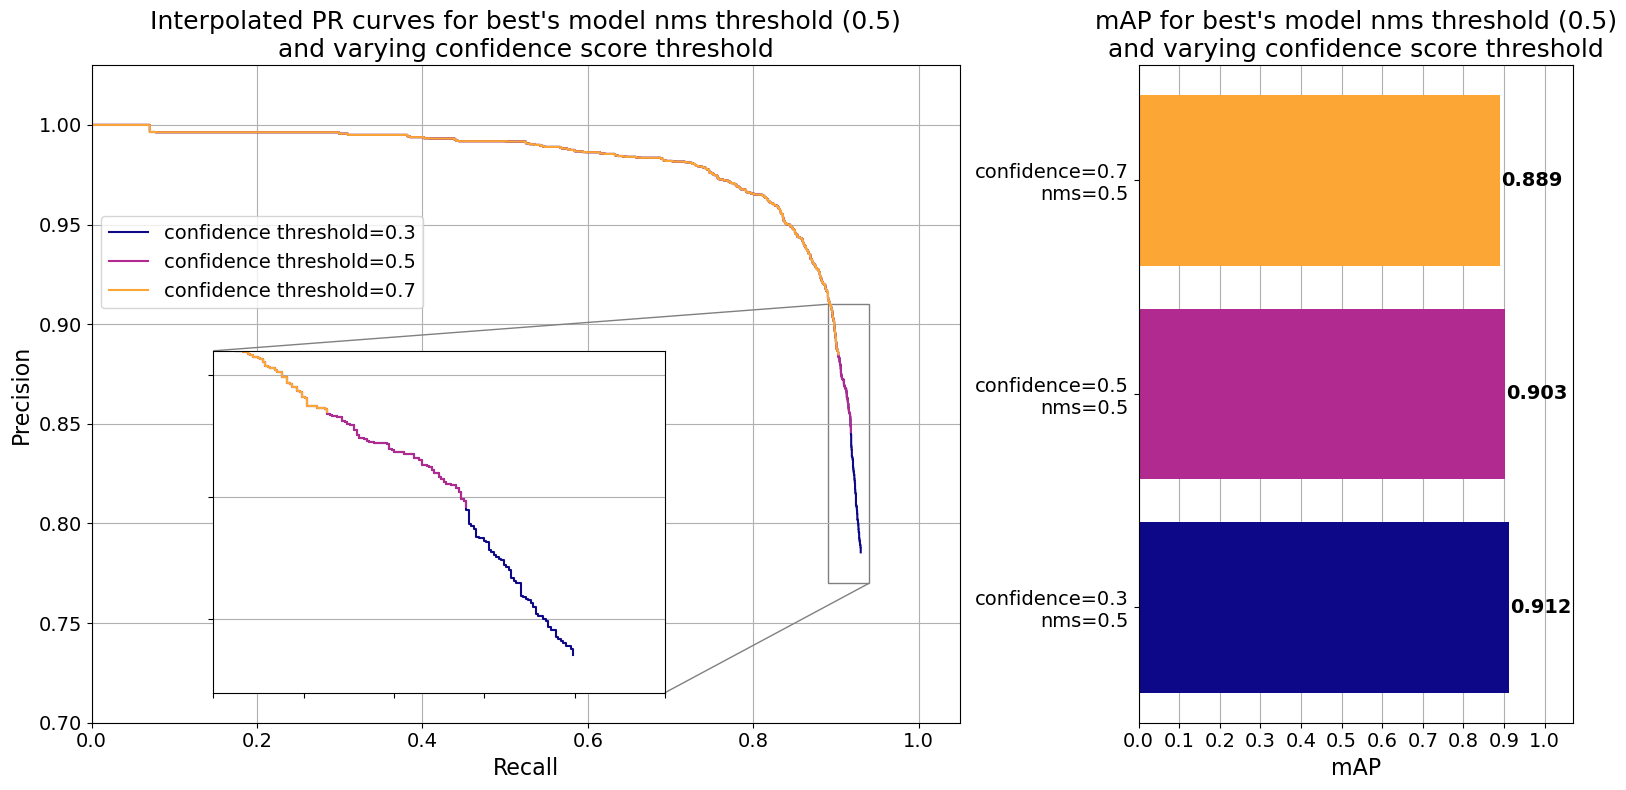

/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_25078/3317248645.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


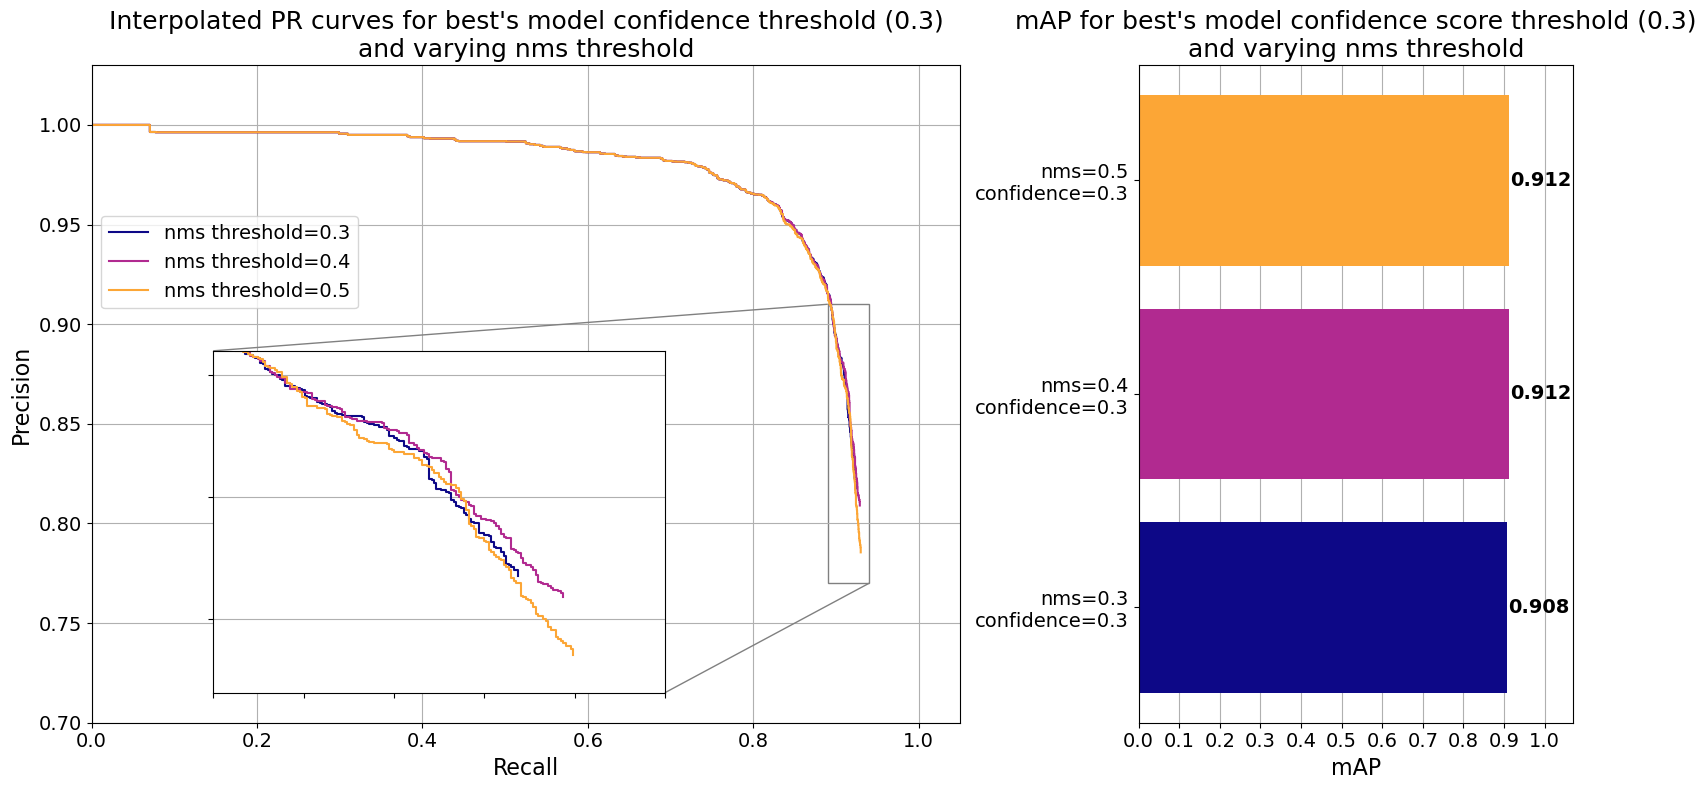

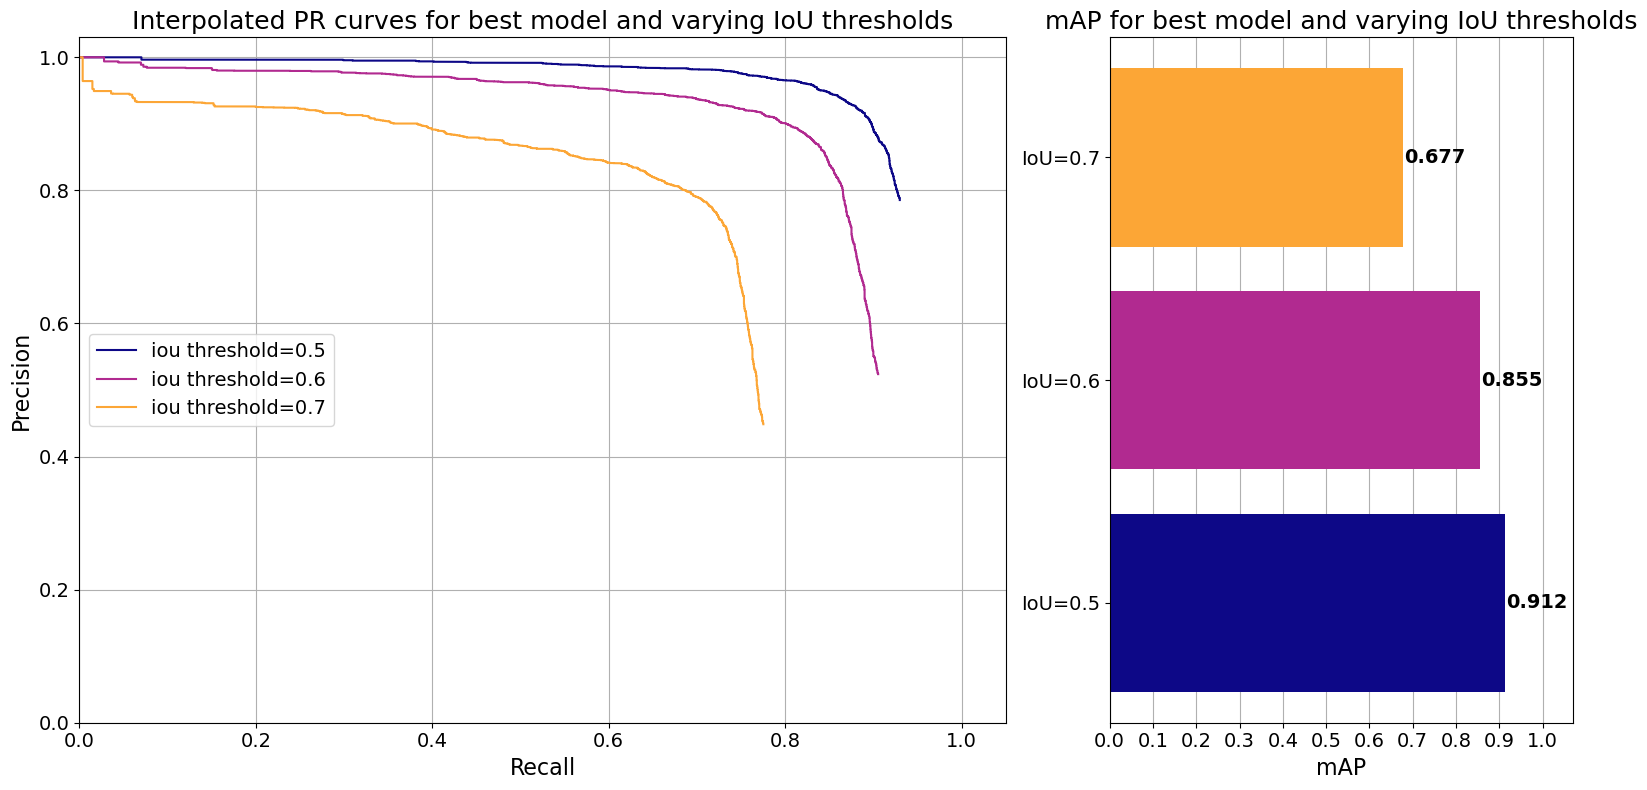

In [53]:
draw_all_plots(validation_results_filepath)

# Detection results for the best Faster R-CNN model

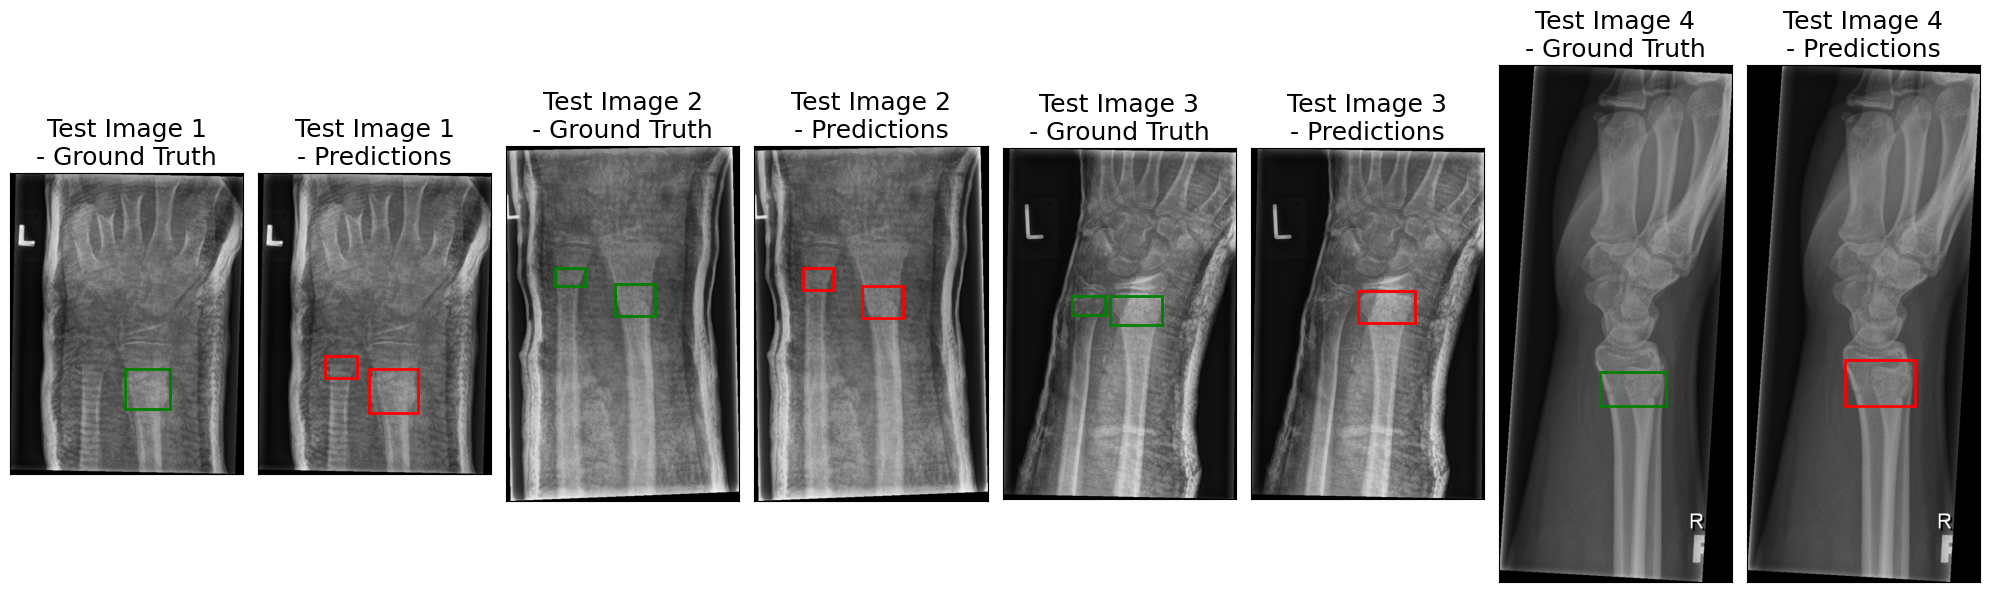

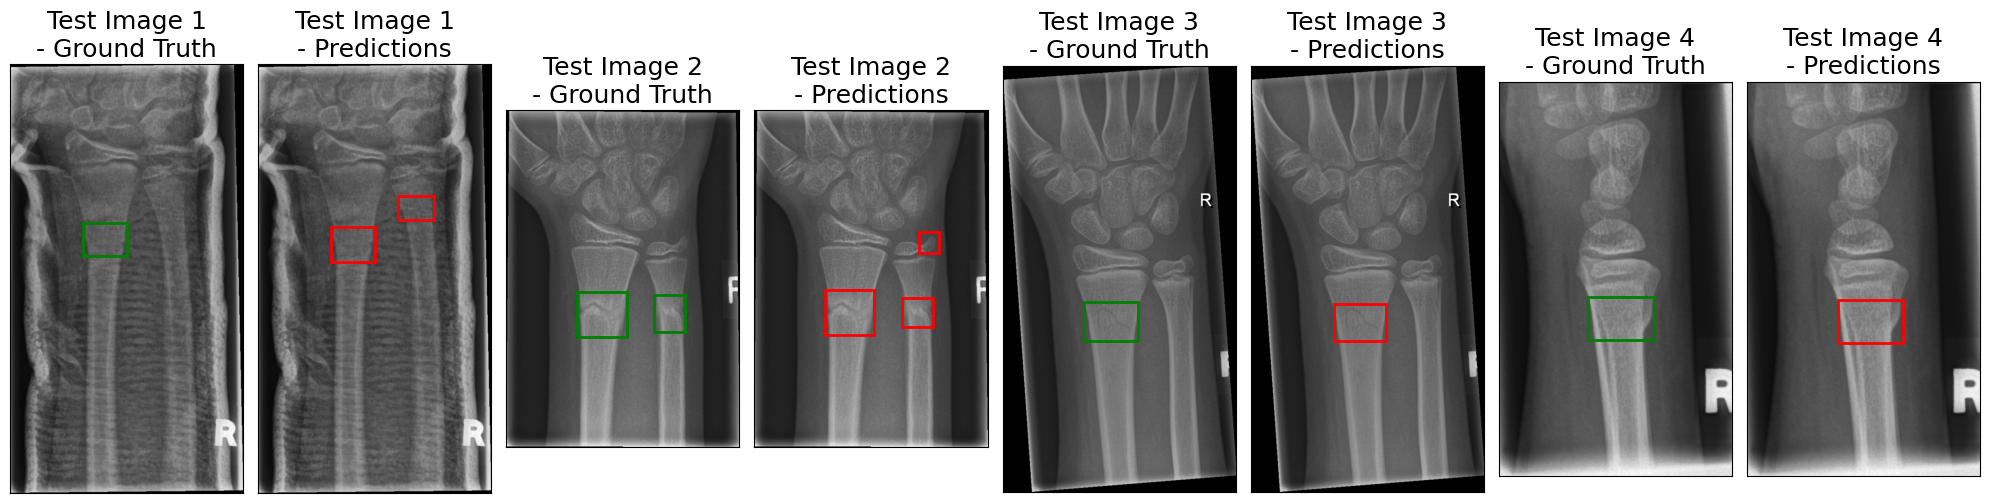

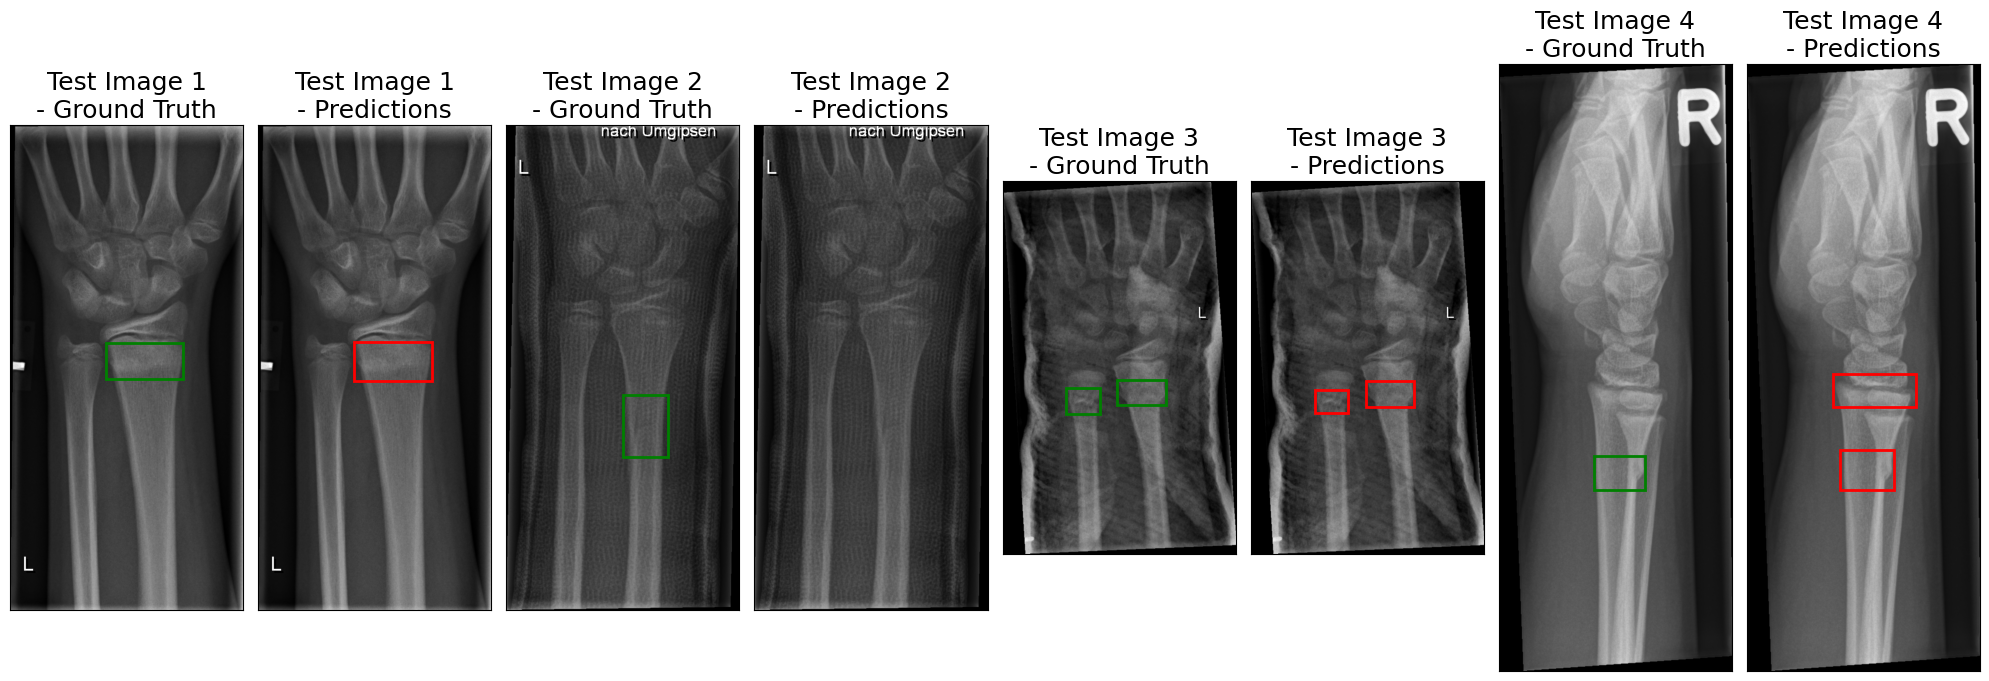

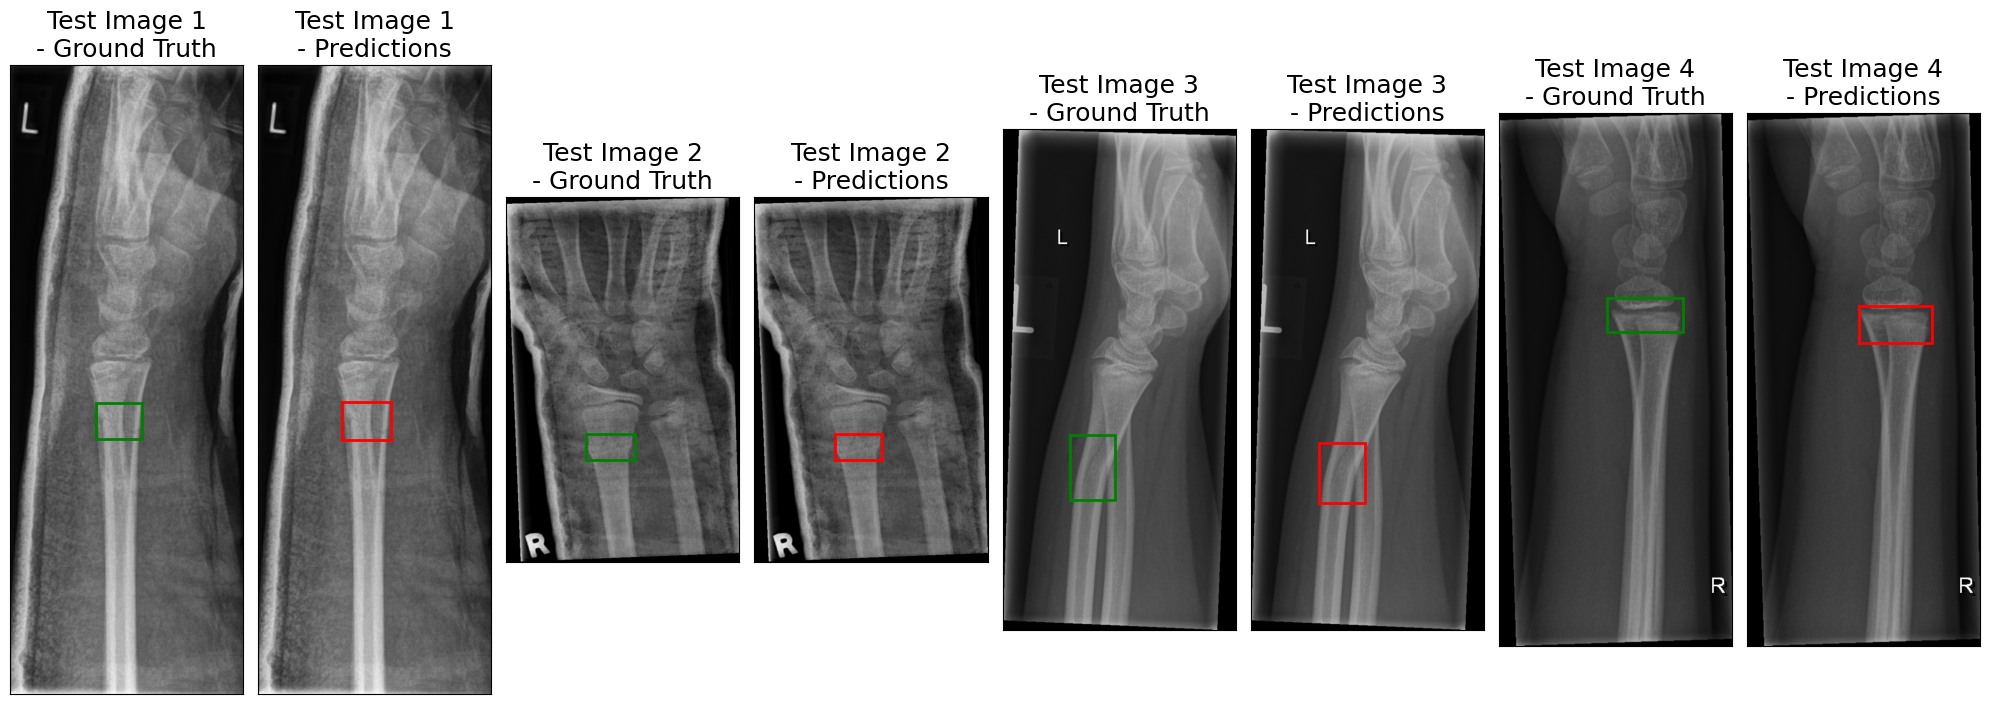

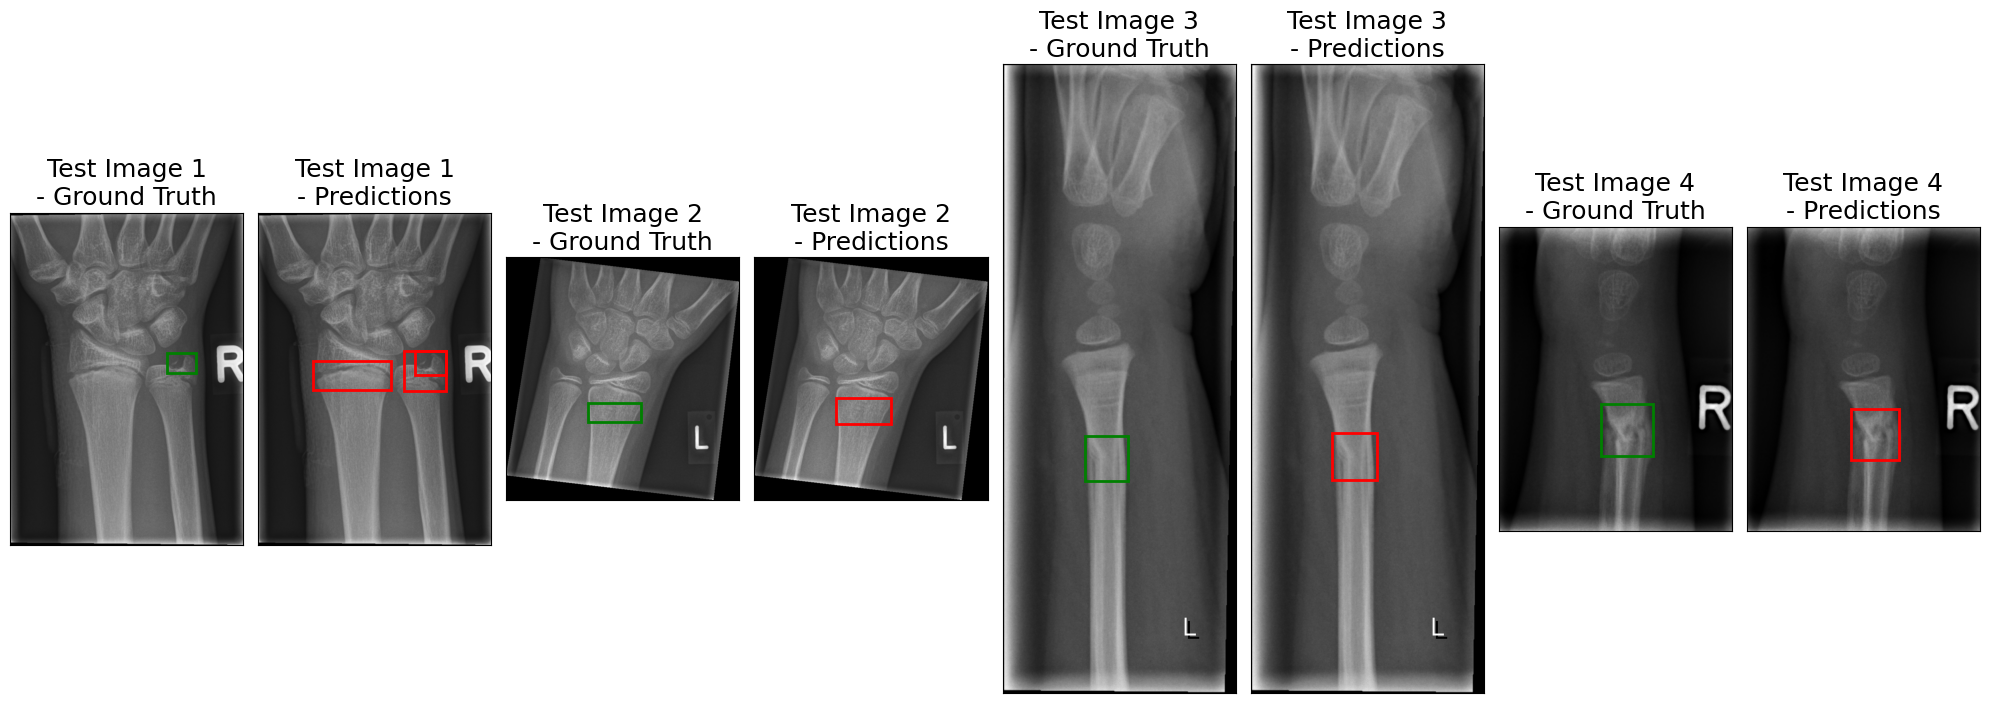

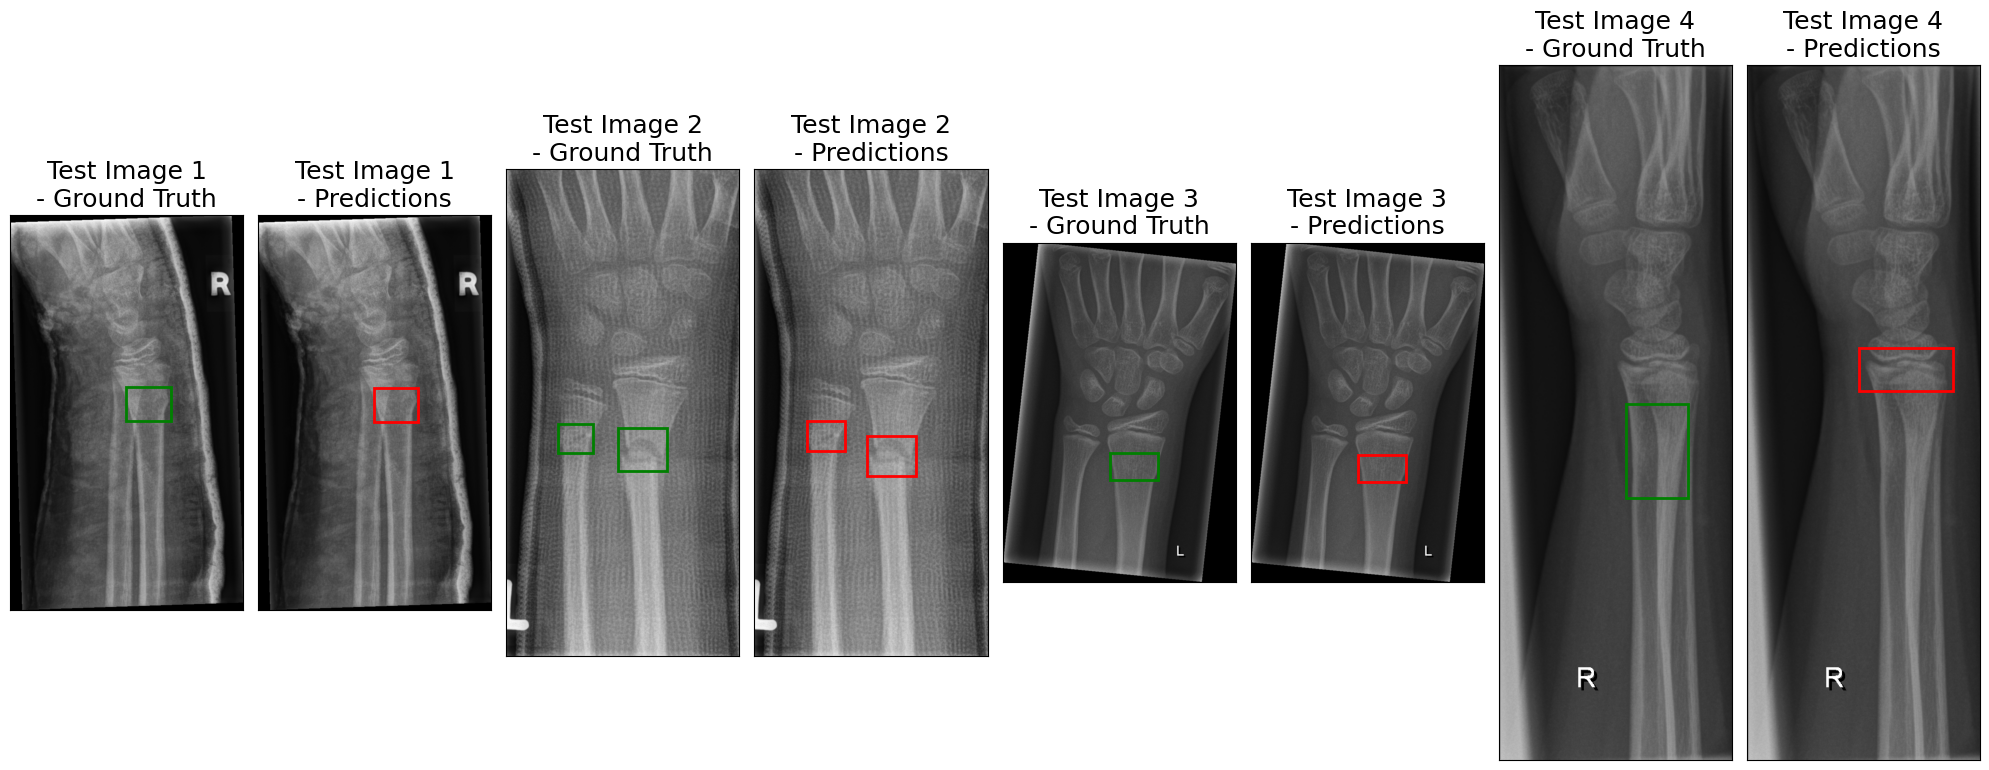

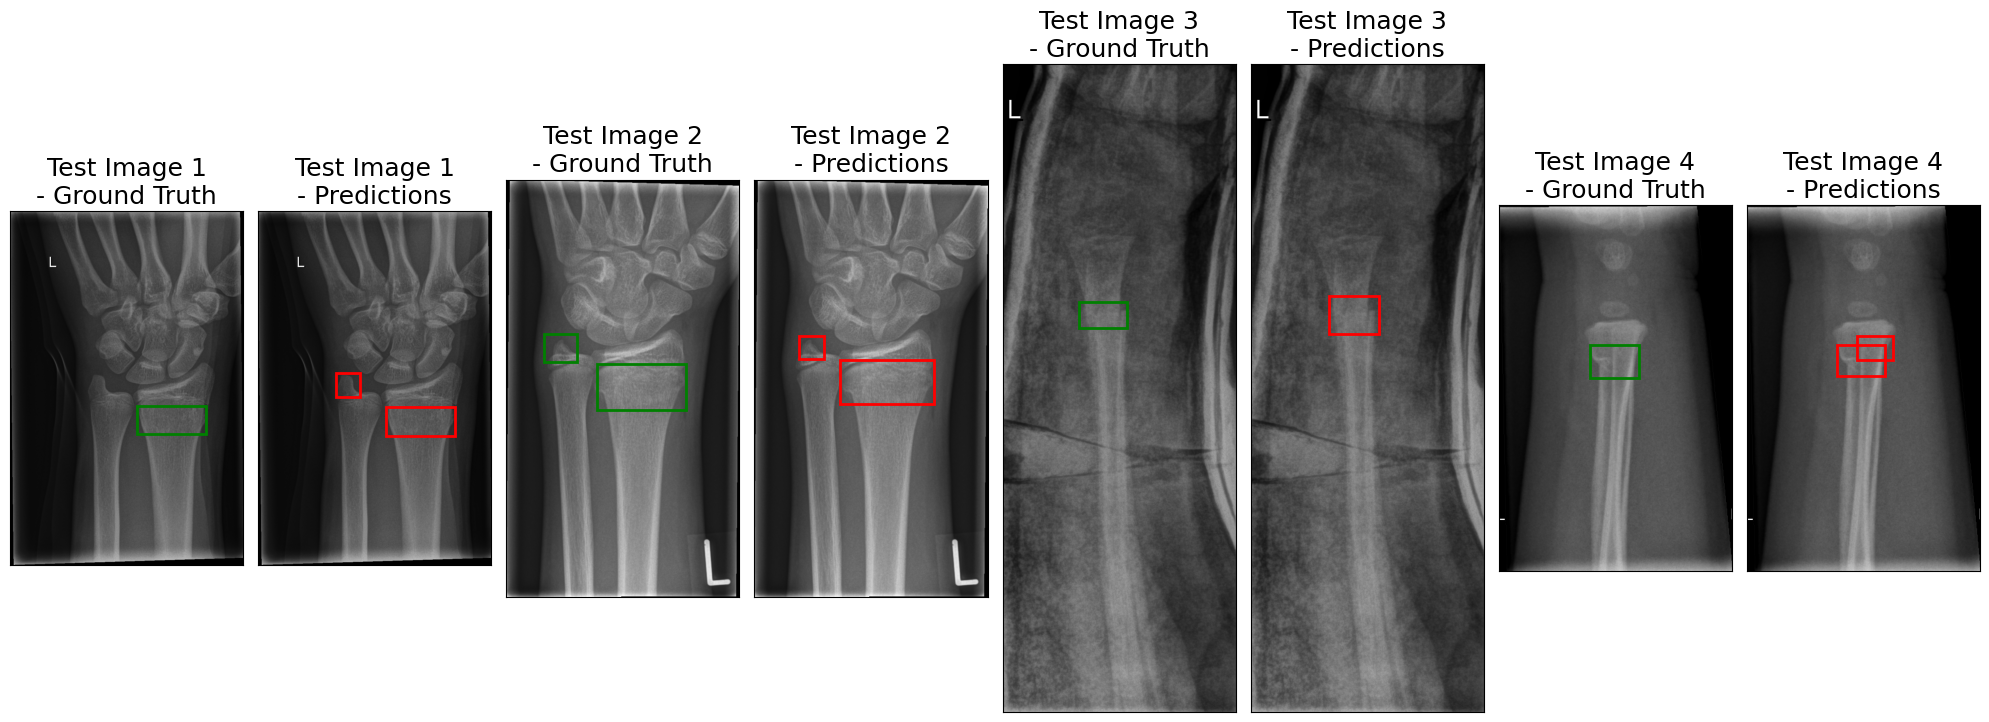

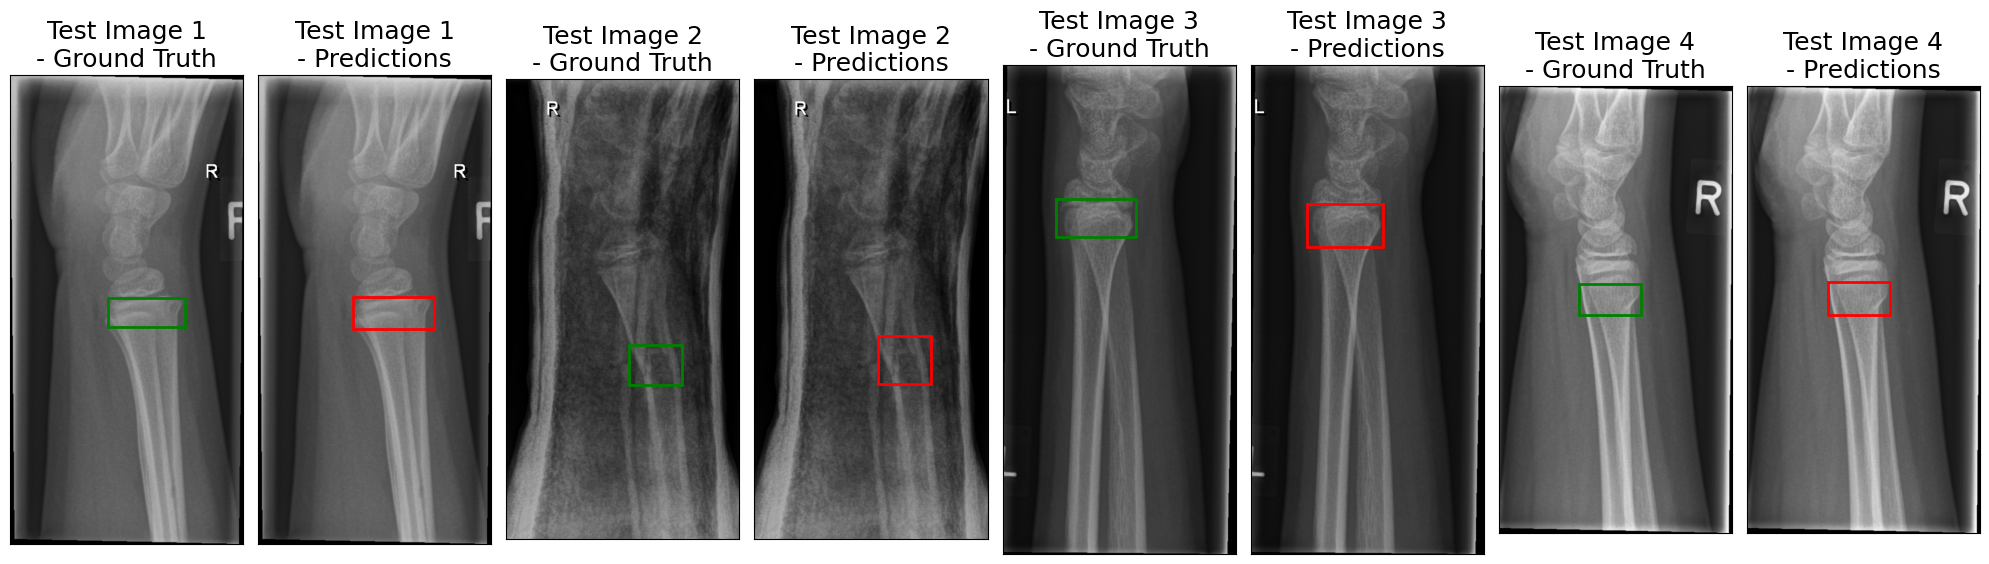

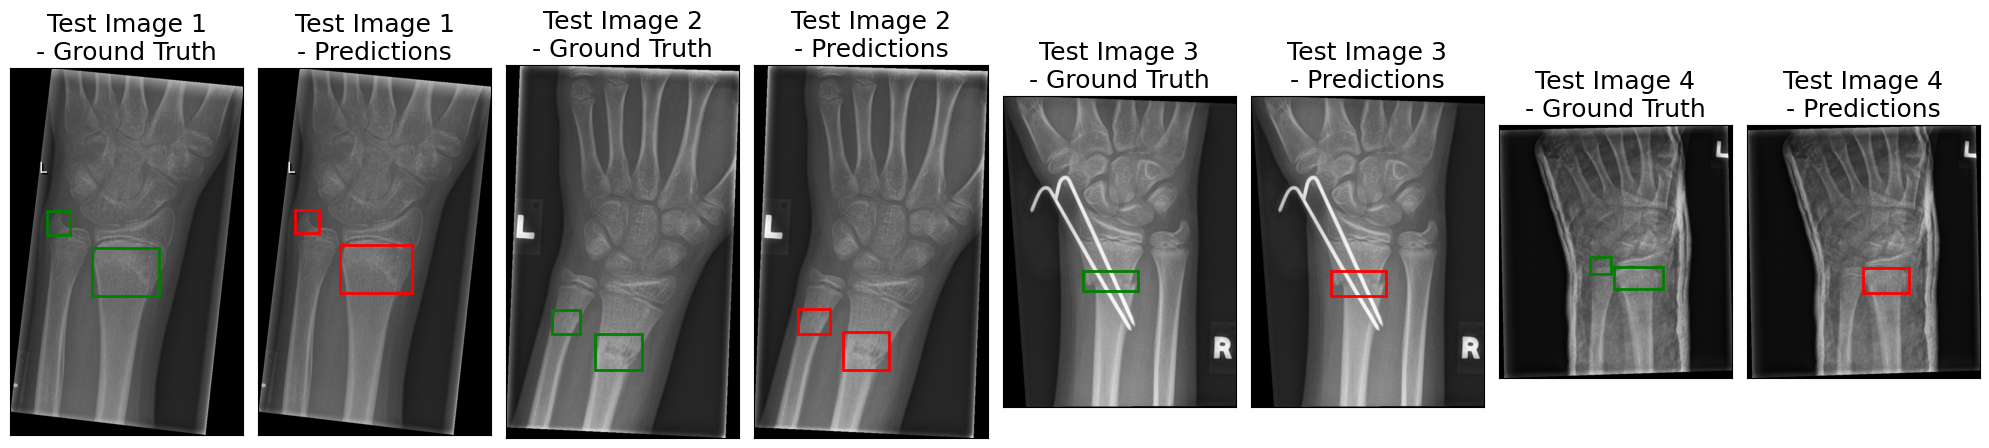

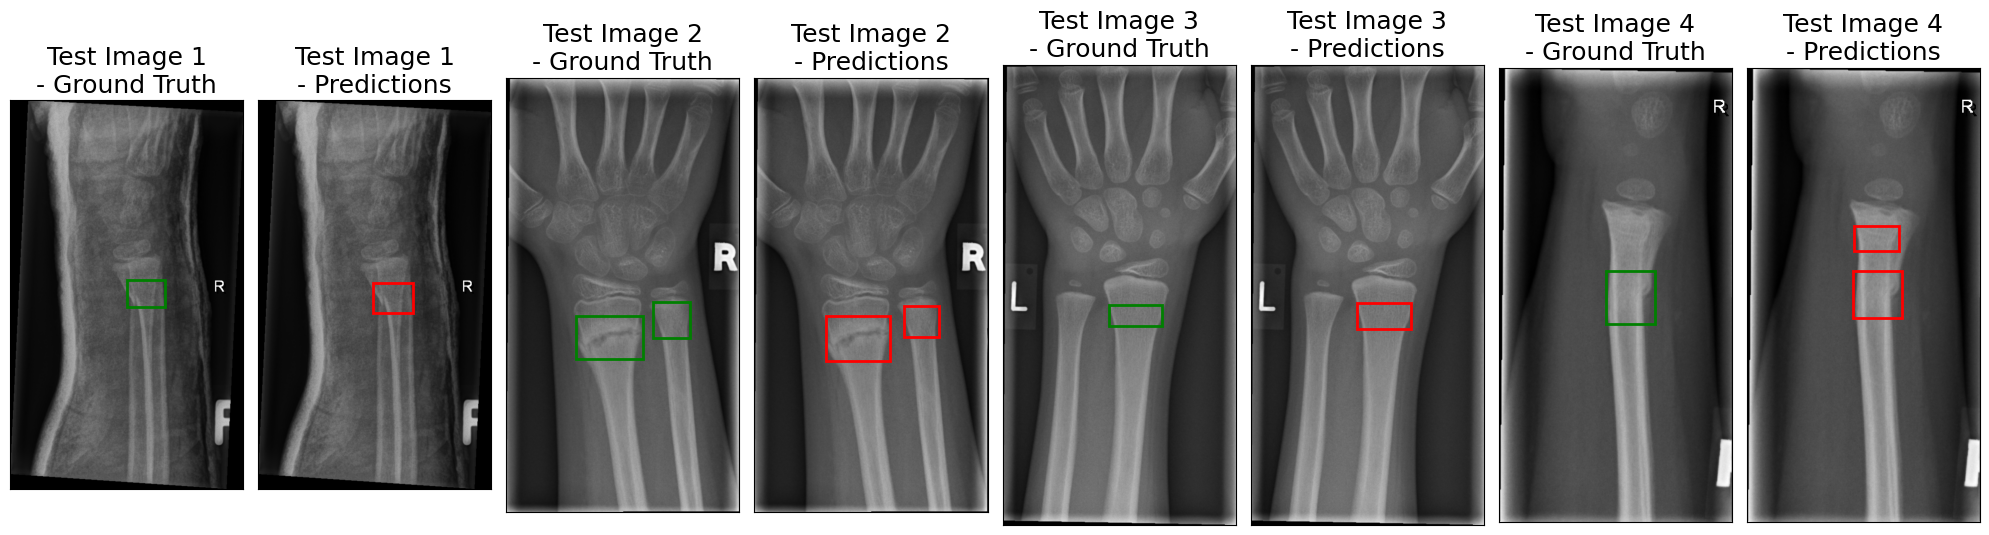

In [54]:
nms_thresh_best = 0.5
confidence_score_thresh_best = 0.3
best_model = modify_model_roi_thresholds(model, nms_thresh=nms_thresh_best, score_thresh=confidence_score_thresh_best)

for i in range(10):
    model_predict(best_model, test_loader=test_loader, idx_test=i)